In [1]:
import scanpy as sc
import numpy as np
import torch
from ndreamer import NDreamer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def plot_distribution_with_binary_zscore(vector, gene_name):
    """
    Plots the distribution of the values in the vector, calculates the z-score
    based on the proportion of values > 0 using CLT, and uses the gene name and z-score
    as the title of the plot.

    Args:
    - vector (numpy.ndarray or list): The input vector of values.
    - gene_name (str): The gene name to include in the title.

    Returns:
    - None: Displays the plot.
    """
    # Convert to numpy array if not already
    vector = np.array(vector)

    # Binary transformation: count the number of values > 0
    count_positive = np.sum(vector > 0)+0.5*np.sum(vector==0)
    n = len(vector)
    proportion_positive = count_positive / n  # Proportion of values > 0

    # Calculate z-score using the CLT
    p_null = 0.5  # Null hypothesis: Proportion of values > 0 is 0.5
    std_error = np.sqrt(p_null * (1 - p_null) / n)
    z_score = (proportion_positive - p_null) / std_error

    # Plot the distribution of the vector
    plt.figure(figsize=(8, 6))
    plt.hist(vector, bins=30, alpha=0.7, edgecolor='k', color='blue')
    plt.axvline(0, color='red', linestyle='--', label='Reference: 0')
    plt.title(f"{gene_name} | Z-score: {z_score:.2f} (Proportion > 0: {proportion_positive:.2f})", fontsize=14)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_distribution(vector, bins=30, kde=True, title="Distribution Plot"):
    """
    Plots the distribution of a vector using a histogram and optionally overlays a KDE fitted line.

    Parameters:
    - vector (array-like): The input data vector.
    - bins (int): Number of bins for the histogram. Default is 30.
    - kde (bool): Whether to add a KDE fitted line. Default is True.
    - title (str): Title for the plot. Default is "Distribution Plot".
    """
    plt.figure(figsize=(8, 6))

    # Plot histogram and optionally the KDE
    sns.histplot(vector, bins=bins, kde=kde, color='blue', stat='density', edgecolor='black')

    # Add titles and labels
    plt.title(title, fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_distribution1(vector, bins=30, kde=True, title="Distribution Plot"):
    """
    Plots the distribution of a vector using a histogram and optionally overlays a KDE fitted line and a normal distribution.

    Parameters:
    - vector (array-like): The input data vector.
    - bins (int): Number of bins for the histogram. Default is 30.
    - kde (bool): Whether to add a KDE fitted line. Default is True.
    - title (str): Title for the plot. Default is "Distribution Plot".
    """
    plt.figure(figsize=(8, 6))

    # Plot histogram and optionally the KDE
    sns.histplot(vector, bins=bins, kde=kde, color='blue', stat='density', edgecolor='black')

    # Overlay the normal distribution curve
    mean, std = np.mean(vector), np.std(vector)
    x = np.linspace(min(vector), max(vector), 1000)
    plt.plot(x, norm.pdf(x, mean, std), color='red', label=f'Normal Dist. (μ={mean:.2f}, σ={std:.2f})')

    # Add titles, labels, and legend
    plt.title(title, fontsize=14)
    plt.xlabel("Value", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [3]:
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

def zscores_to_adjusted_pvalues(z_scores, adjustment_method='fdr_bh'):
    """
    Convert z-scores to two-sided p-values and adjust them for multiple comparisons.

    Parameters:
        z_scores (array-like): Vector of z-scores.
        adjustment_method (str): Method for p-value adjustment. 
                                 Options include 'bonferroni', 'fdr_bh', etc.
                                 (default is 'fdr_bh').

    Returns:
        dict: A dictionary containing:
              - 'z_scores': The original z-scores.
              - 'p_values': The two-sided p-values.
              - 'adjusted_p_values': The adjusted p-values.
    """
    # Convert z-scores to two-sided p-values
    p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))
    p_values = np.nan_to_num(p_values, nan=0)
    # Adjust p-values for multiple comparisons
    adjusted_p_values = multipletests(p_values, method=adjustment_method)[1]
    
    return adjusted_p_values

In [4]:
import pandas as pd
def Plot_and_Estimate_CATE_adata(
    adata,
    indices,
    genes=None,
    topk=20,
    plot=True,
    parametric=False
):
    # Subset the ITE matrix using the selected indices
    ITE_subset = adata.X[indices, :]

    # Initialize z-scores for genes
    z_scores = []

    # Calculate z-scores for each gene (column in the ITE matrix)
    for gene_idx in range(ITE_subset.shape[1]):
        gene_ite = ITE_subset[:, gene_idx]
        # Test if ITE > 0 using non-parametric test (binomial distribution assumption)
        n = len(gene_ite)
        successes = np.sum(gene_ite > 0) + 0.5*np.sum(gene_ite==0)
        # z-score for binomial test
        z_score = (successes - n * 0.5) / np.sqrt(n * 0.25)
        z_scores.append(z_score)
    
    if parametric:
        z_scores = []
        for gene_idx in range(ITE_subset.shape[1]):
            gene_ite = ITE_subset[:, gene_idx]
            # Test if ITE > 0 using non-parametric test (binomial distribution assumption)
            n = len(gene_ite)
            # z-score for binomial test
            z_score = np.mean(gene_ite)/np.std(gene_ite, ddof=1)*np.sqrt(n)
            z_scores.append(z_score)
    
    # Select top-k significant genes if `genes` is not provided
    z_scores = np.array(z_scores)
    #plot_distribution(z_scores)
    p_adjs=zscores_to_adjusted_pvalues(z_scores)
    #plot_distribution(2 * (1 - norm.cdf(np.abs(z_scores))))
    if genes is None:
        # Get indices of top-k absolute z-scores
        topk_indices = np.argsort(-np.abs(z_scores))[:topk]
        genes = adata.var_names[topk_indices]

    print("Number of genes with ITE adjusted p-values less than 0.01",np.sum(p_adjs<0.01))
    
    # Print the selected most significant genes
    print("Selected most significant genes:")
    genes=genes.tolist()

    df=pd.DataFrame({"Gene":genes, "Z score":np.array([z_scores[adata.var_names.tolist().index(gene)] for gene in genes]),
                    "Adjusted_p":np.array([p_adjs[adata.var_names.tolist().index(gene)] for gene in genes])})
    print(df)

    if plot:
        # Plot the distribution of ITE values for the selected genes
        plt.figure(figsize=(10, 6))
        for gene in genes:
            print("Plotting:", gene)
            print("adjusted p-value:",p_adjs[adata.var_names.tolist().index(gene)])
            gene_idx = np.where(adata.var_names == gene)[0][0]
            ite_values = ITE_subset[:, gene_idx]

            plot_distribution_with_binary_zscore(vector=ite_values, gene_name=gene)

    # Return only the z-score
    return z_scores

Number of genes with ITE adjusted p-values less than 0.01 325
Selected most significant genes:
       Gene    Z score  Adjusted_p
0    CYP1B1 -30.329551         0.0
1   ALDH3A1 -24.801255         0.0
2     HSPB1  17.320304         0.0
3    BPIFB1 -16.255219         0.0
4      FOSB  16.204501         0.0
5    GPRC5A  15.164776         0.0
6     ANXA1  14.505437         0.0
7    ERRFI1  14.353283         0.0
8      RERG  14.277205         0.0
9     DUSP5  13.262839         0.0
10     KRT4  13.262839         0.0
11   CLDN10 -12.882451         0.0
12    NDRG1  12.425987         0.0
13     ATF3  12.273832         0.0
14    ITPKC  12.147036         0.0
15    FAM3D -12.045599         0.0
16     KRT5  11.969522         0.0
17   ATP12A  11.589135         0.0
18    KRT17  11.462339         0.0
19  GADD45B  11.411620         0.0
Plotting: CYP1B1
adjusted p-value: 0.0


<Figure size 1000x600 with 0 Axes>

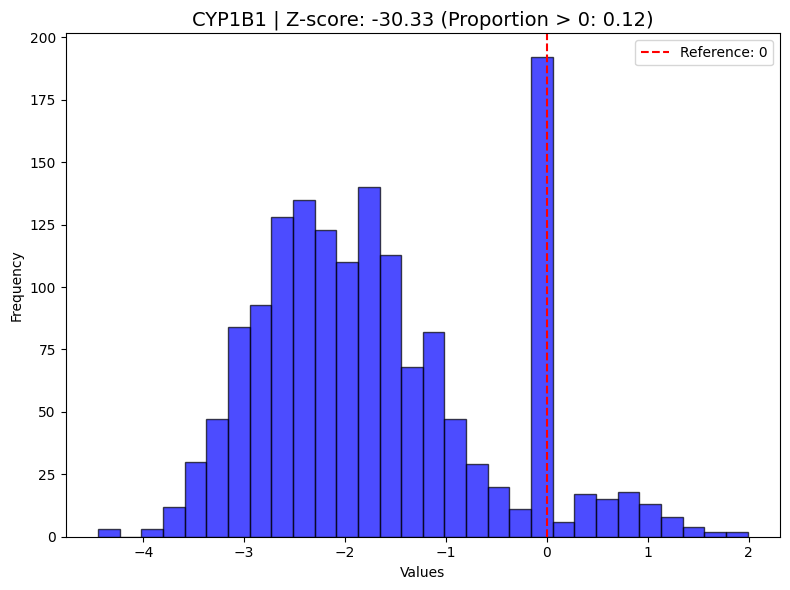

Plotting: ALDH3A1
adjusted p-value: 0.0


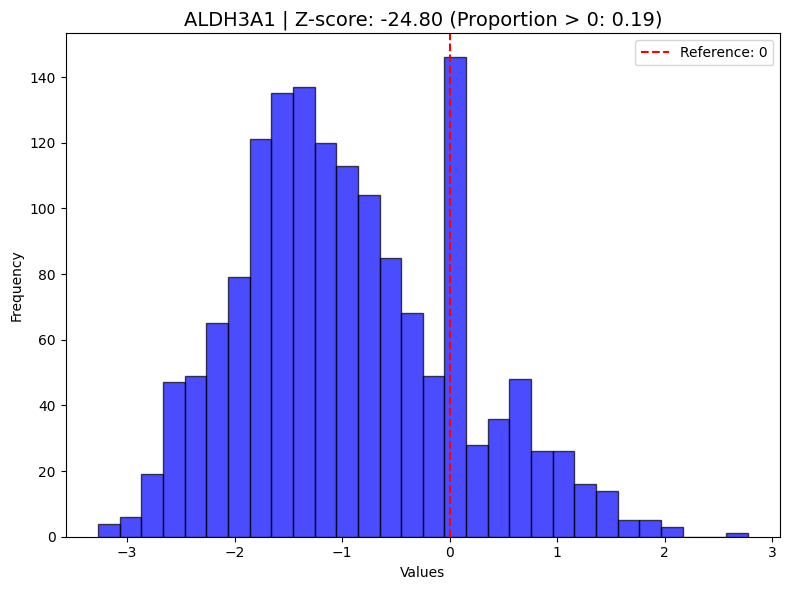

Plotting: HSPB1
adjusted p-value: 0.0


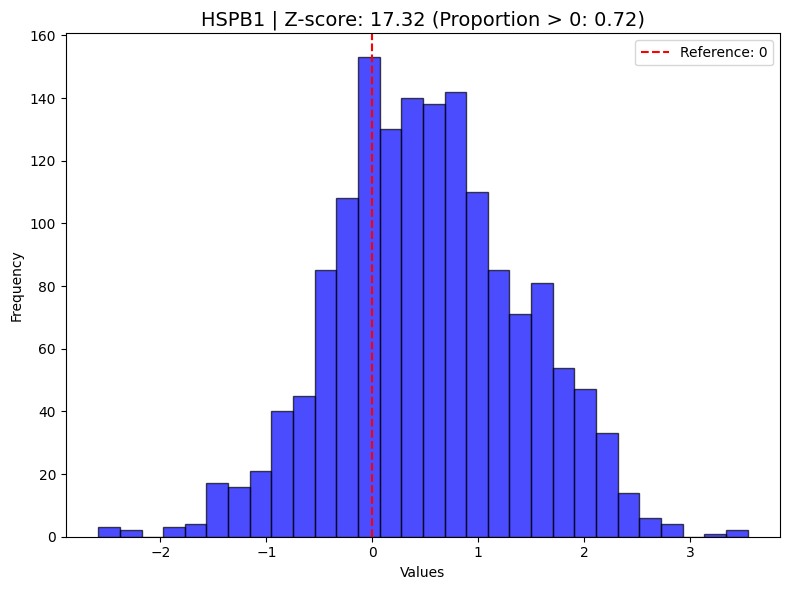

Plotting: BPIFB1
adjusted p-value: 0.0


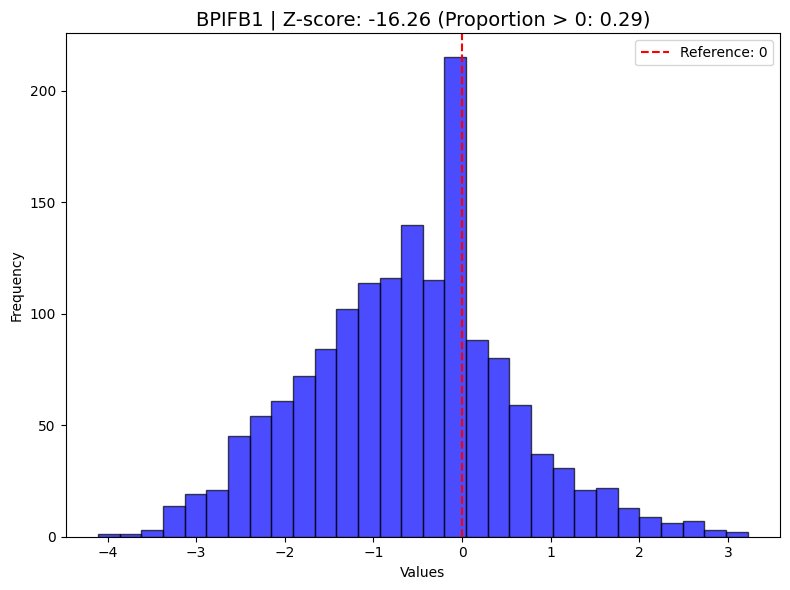

Plotting: FOSB
adjusted p-value: 0.0


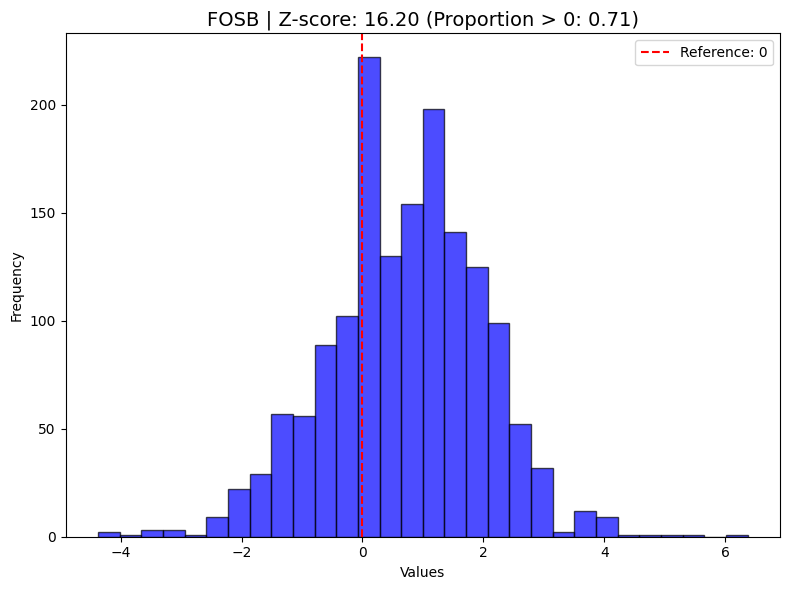

Plotting: GPRC5A
adjusted p-value: 0.0


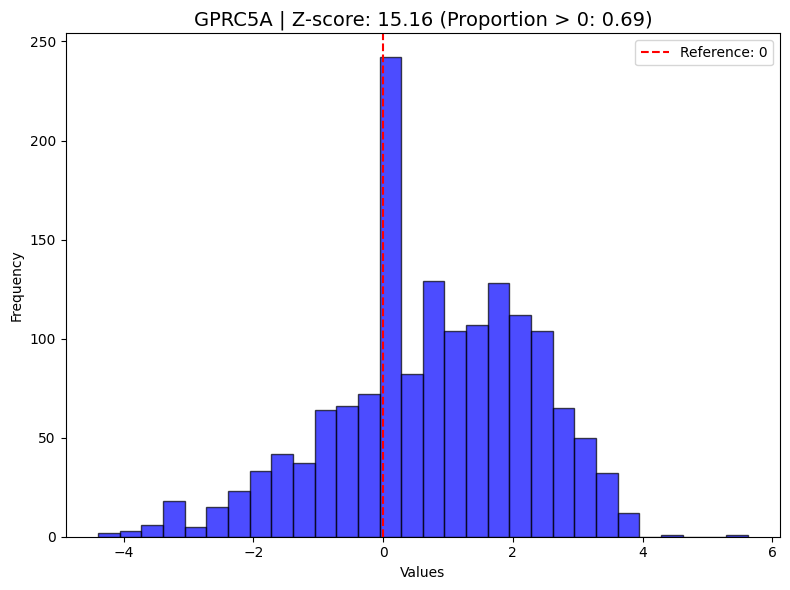

Plotting: ANXA1
adjusted p-value: 0.0


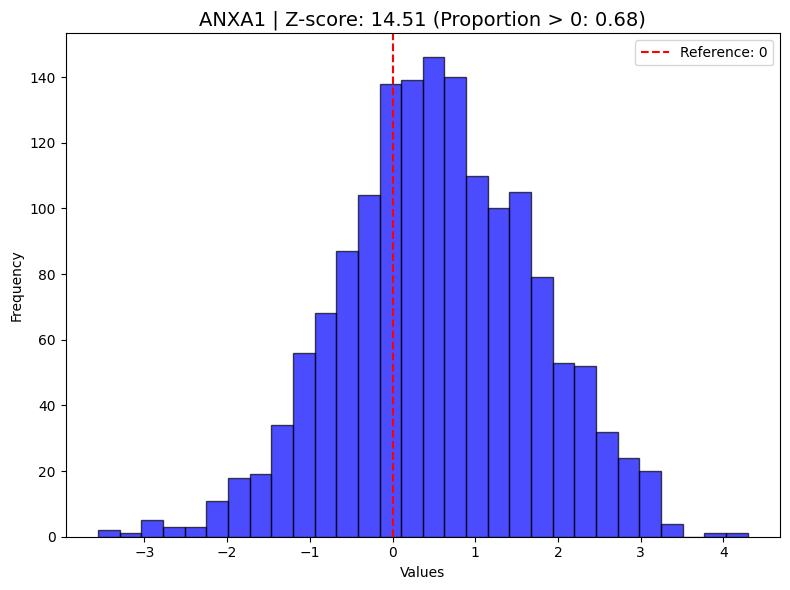

Plotting: ERRFI1
adjusted p-value: 0.0


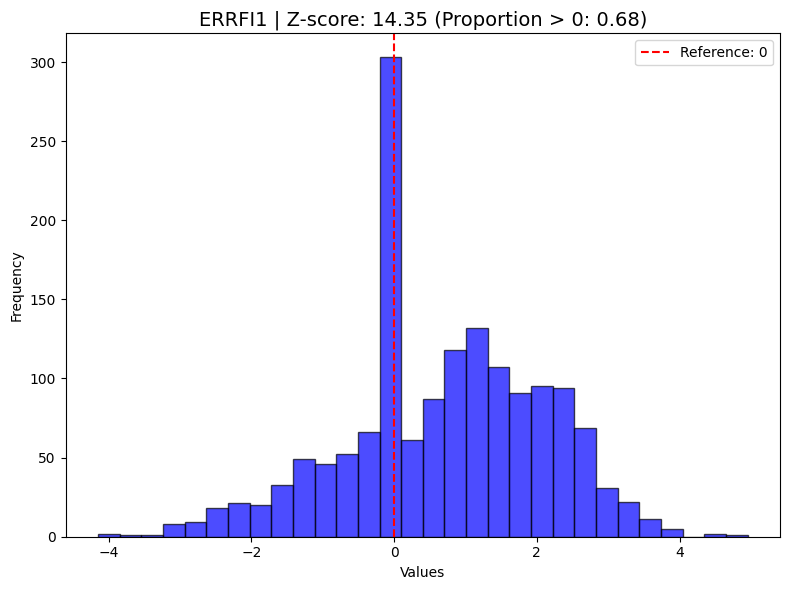

Plotting: RERG
adjusted p-value: 0.0


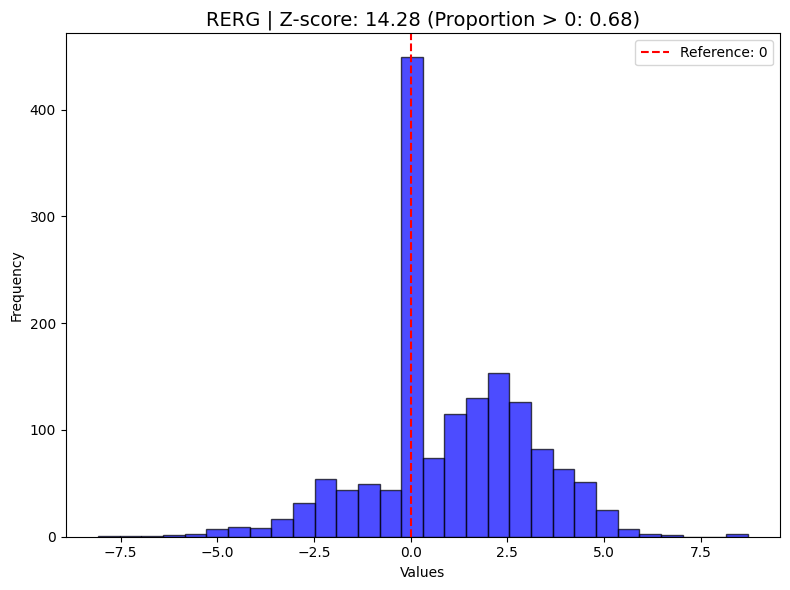

Plotting: DUSP5
adjusted p-value: 0.0


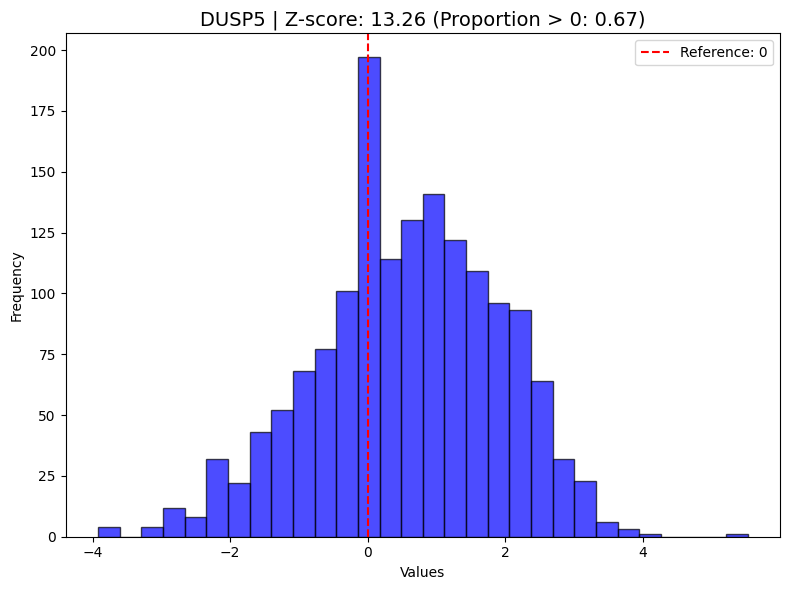

Plotting: KRT4
adjusted p-value: 0.0


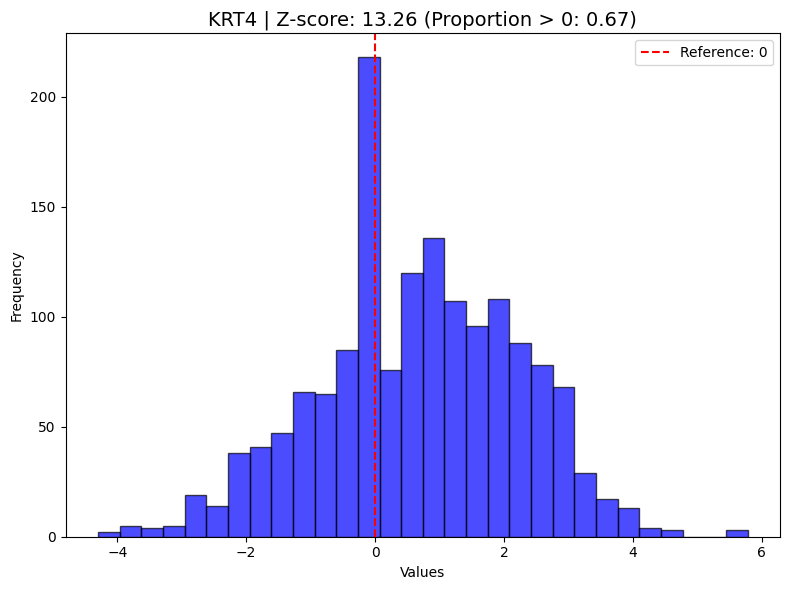

Plotting: CLDN10
adjusted p-value: 0.0


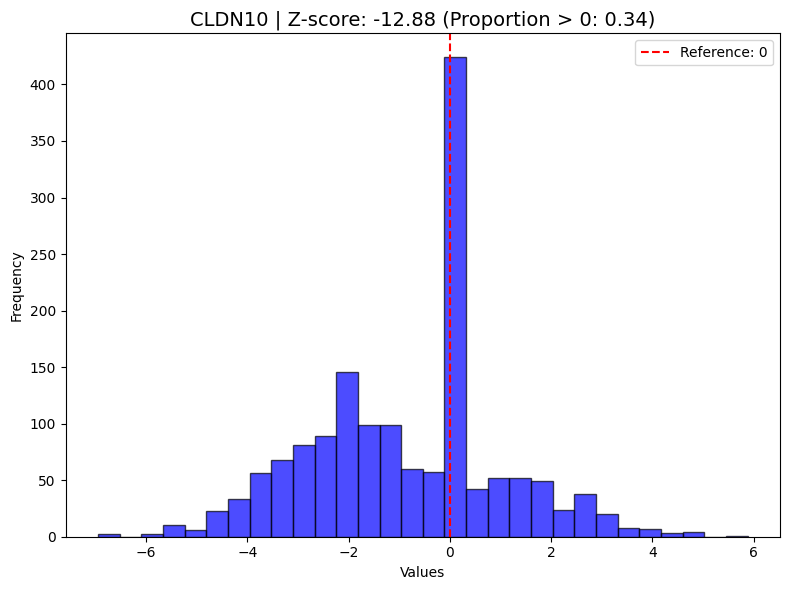

Plotting: NDRG1
adjusted p-value: 0.0


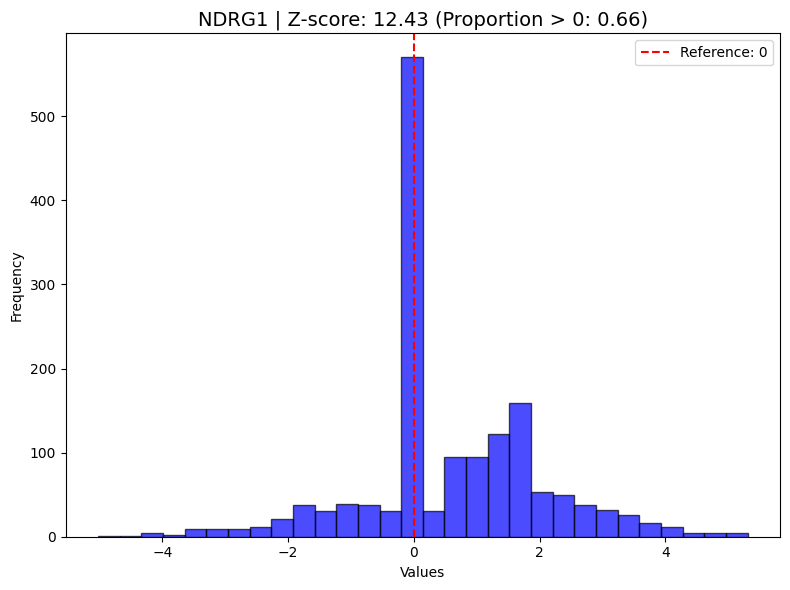

Plotting: ATF3
adjusted p-value: 0.0


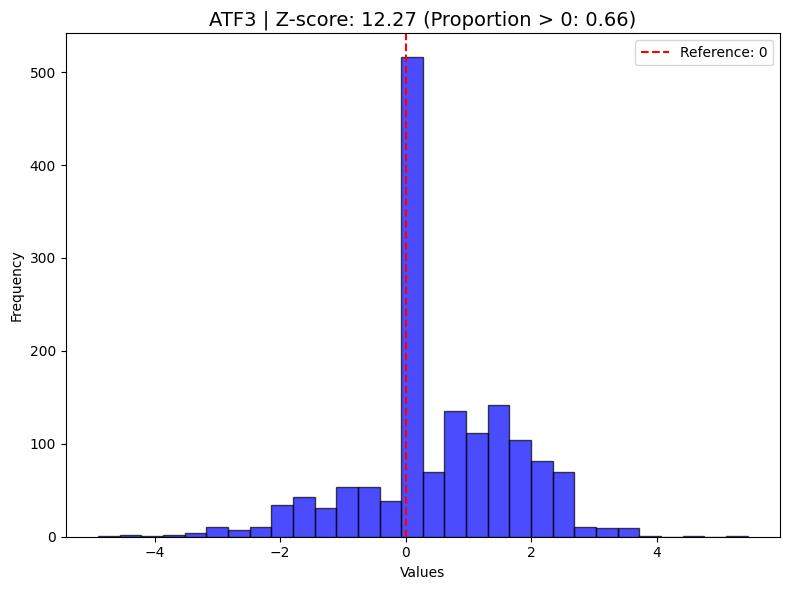

Plotting: ITPKC
adjusted p-value: 0.0


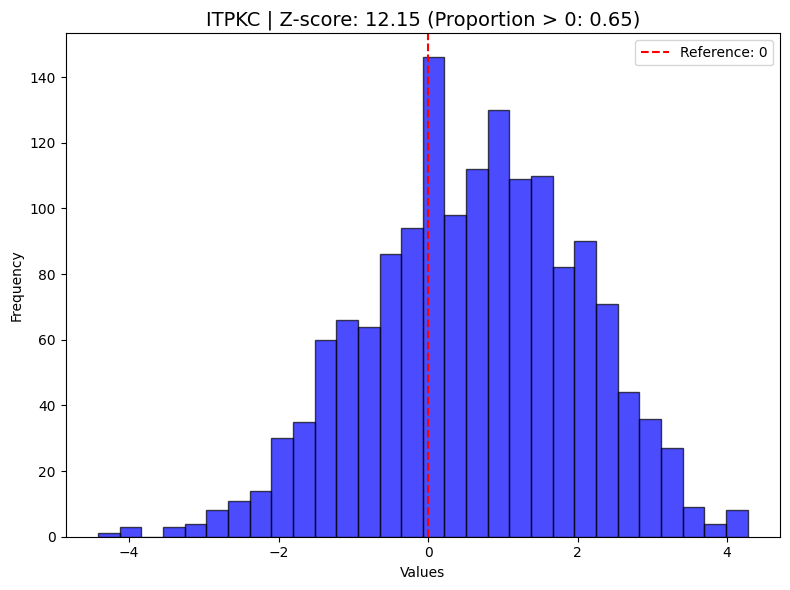

Plotting: FAM3D
adjusted p-value: 0.0


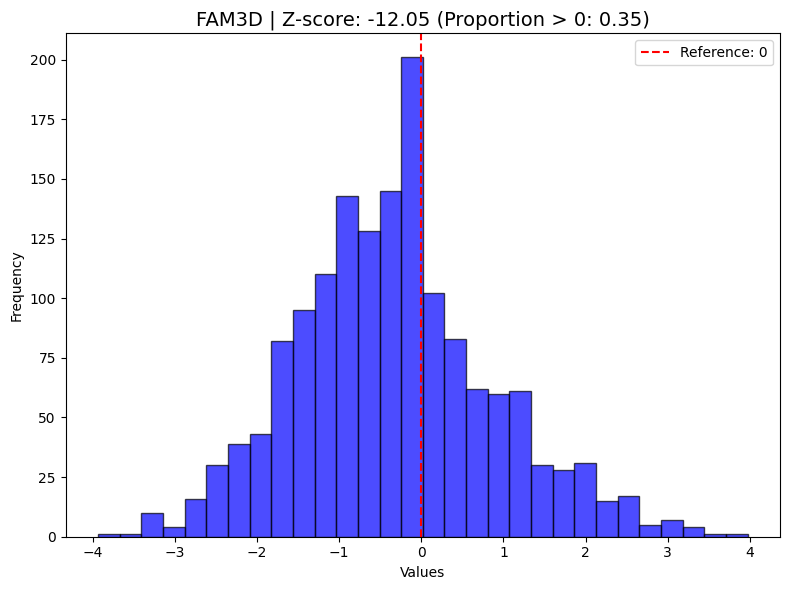

Plotting: KRT5
adjusted p-value: 0.0


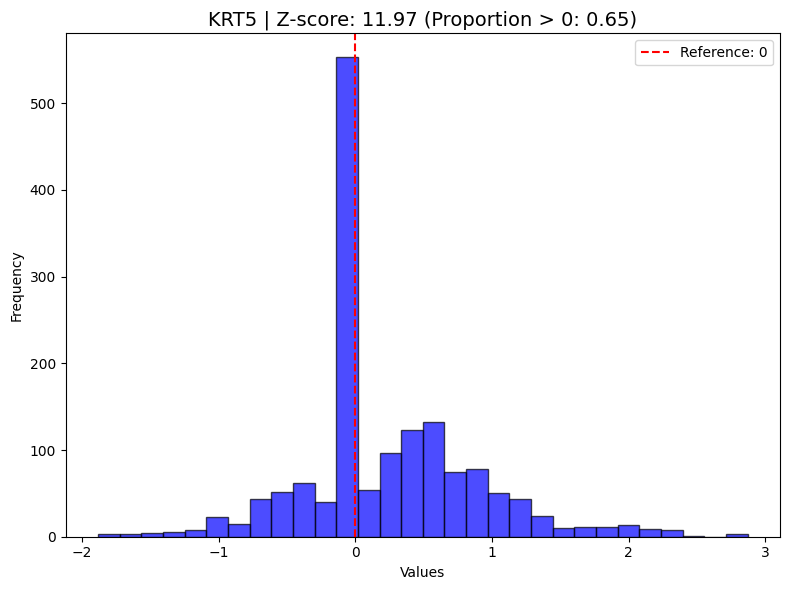

Plotting: ATP12A
adjusted p-value: 0.0


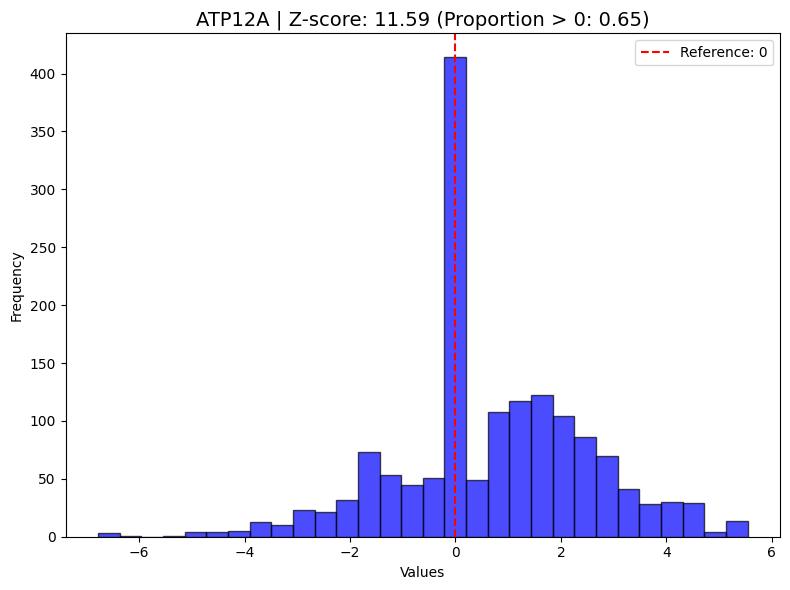

Plotting: KRT17
adjusted p-value: 0.0


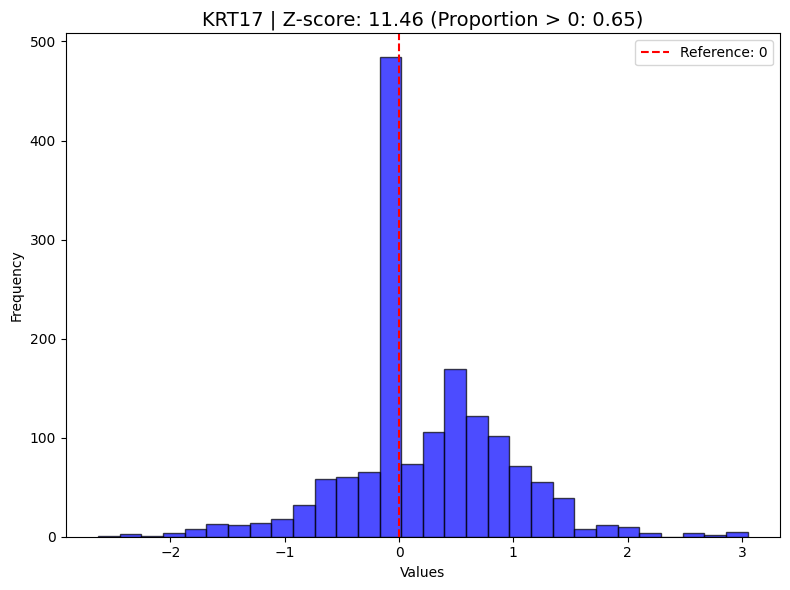

Plotting: GADD45B
adjusted p-value: 0.0


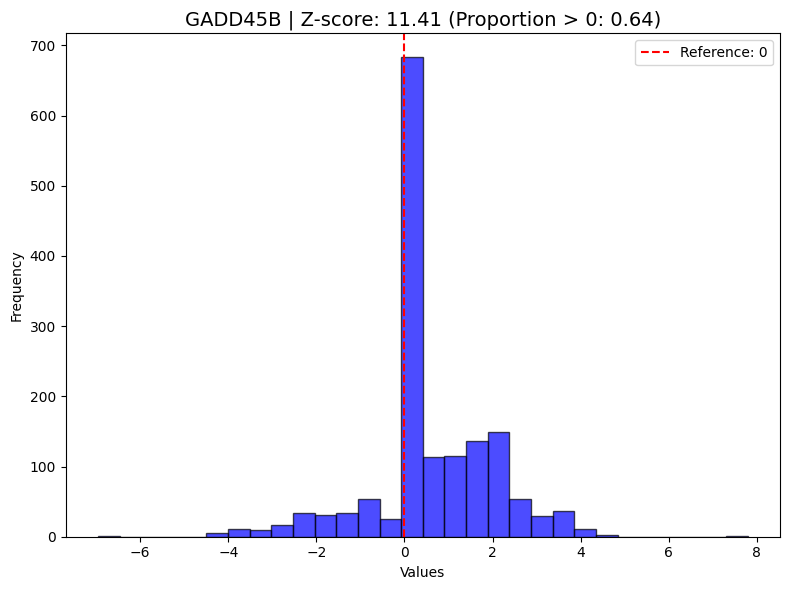

Number of genes with ITE adjusted p-values less than 0.01 636
Selected most significant genes:
       Gene    Z score  Adjusted_p
0    CYP1B1 -58.024085         0.0
1   ALDH3A1 -36.780360         0.0
2     HSPB1  23.494085         0.0
3      FOSB  21.503912         0.0
4    BPIFB1 -20.944808         0.0
5    ERRFI1  19.359760         0.0
6    GPRC5A  19.142116         0.0
7     ANXA1  18.634795         0.0
8      RERG  18.454893         0.0
9    CLDN10 -17.671610         0.0
10     KRT4  16.658165         0.0
11    DUSP5  16.592225         0.0
12    ITPKC  16.532498         0.0
13    NDRG1  16.061873         0.0
14     KRT5  15.583400         0.0
15     ATF3  15.328860         0.0
16   ATP12A  14.733379         0.0
17  GADD45B  14.574605         0.0
18     SOX4  14.255918         0.0
19   TSPAN8 -14.092966         0.0
Plotting: CYP1B1
adjusted p-value: 0.0


<Figure size 1000x600 with 0 Axes>

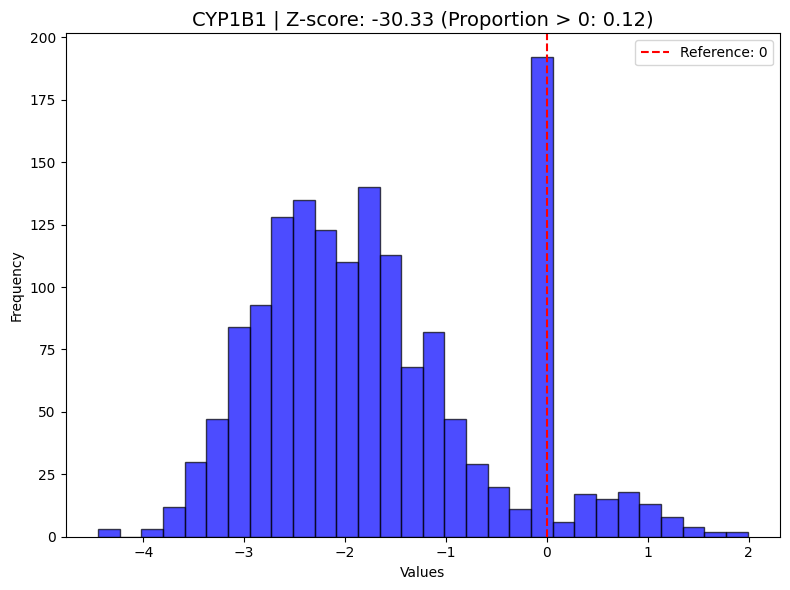

Plotting: ALDH3A1
adjusted p-value: 0.0


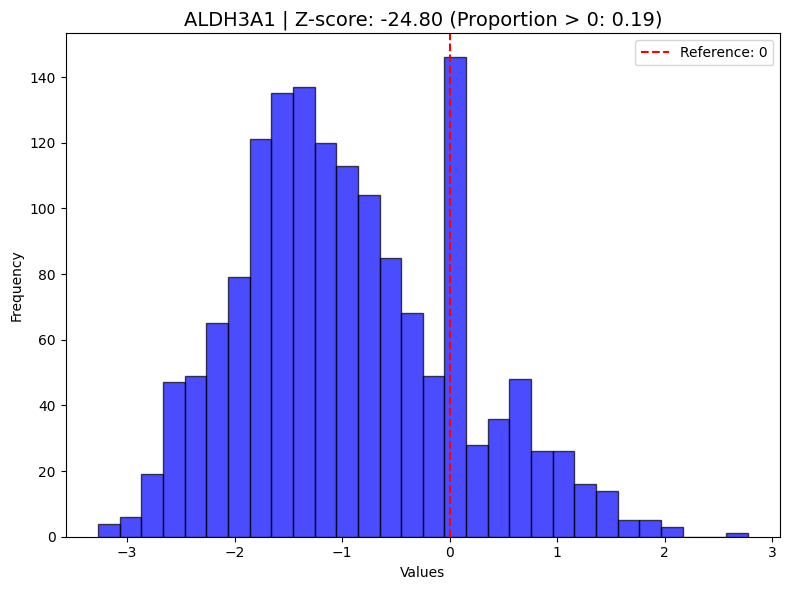

Plotting: HSPB1
adjusted p-value: 0.0


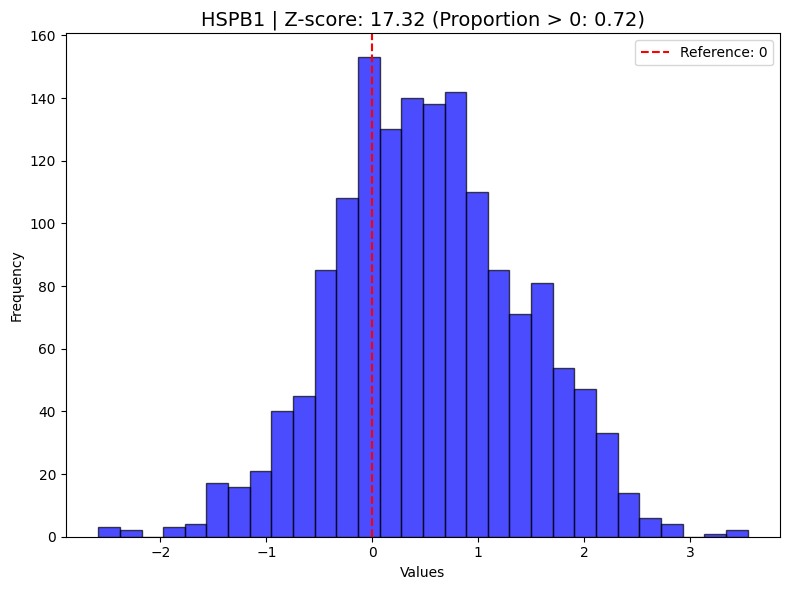

Plotting: FOSB
adjusted p-value: 0.0


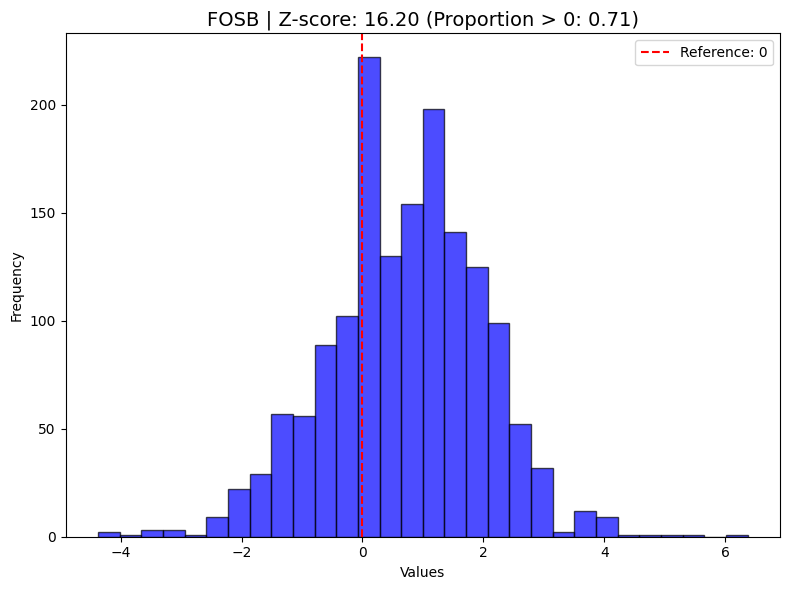

Plotting: BPIFB1
adjusted p-value: 0.0


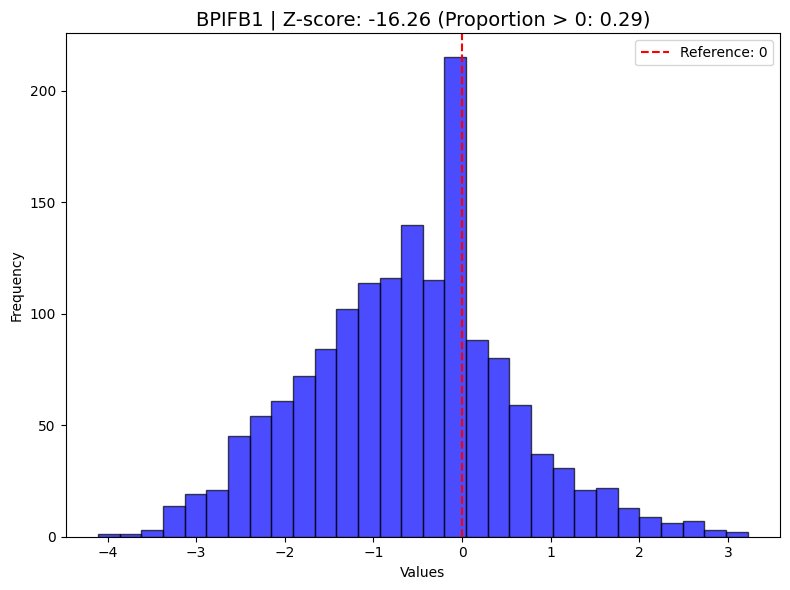

Plotting: ERRFI1
adjusted p-value: 0.0


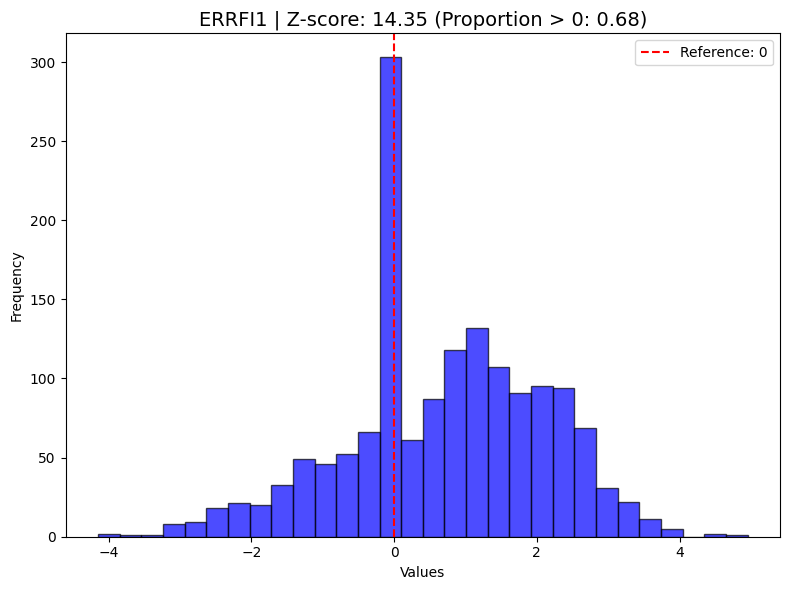

Plotting: GPRC5A
adjusted p-value: 0.0


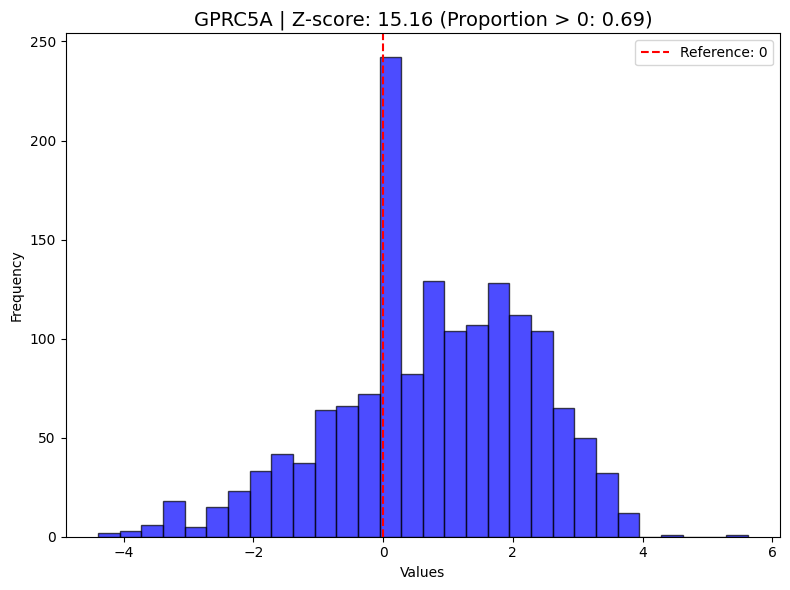

Plotting: ANXA1
adjusted p-value: 0.0


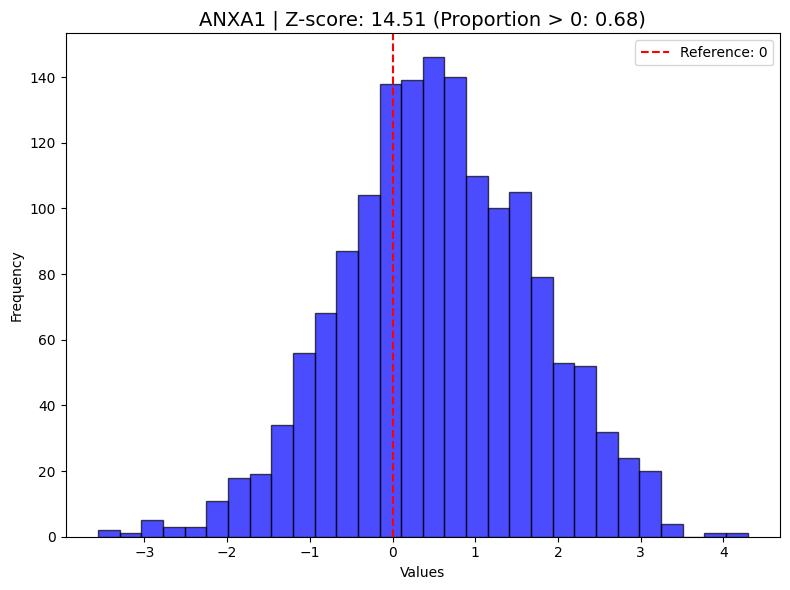

Plotting: RERG
adjusted p-value: 0.0


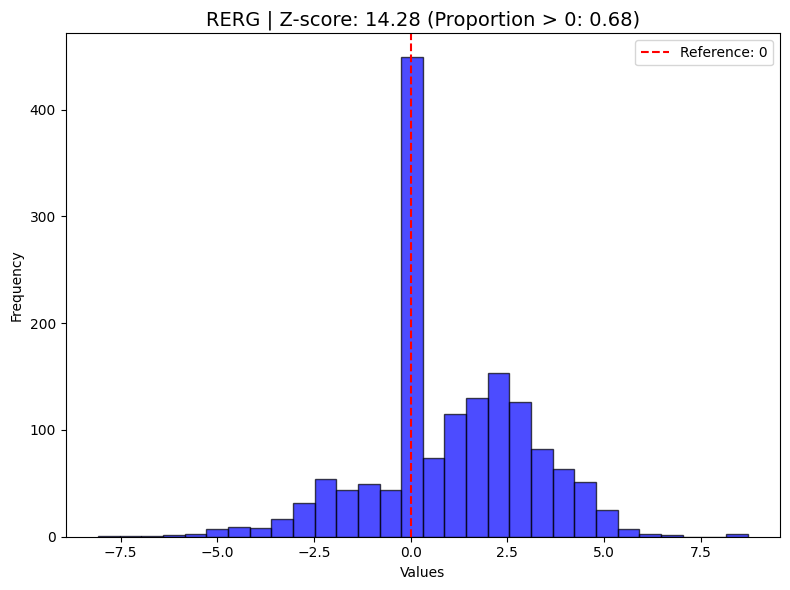

Plotting: CLDN10
adjusted p-value: 0.0


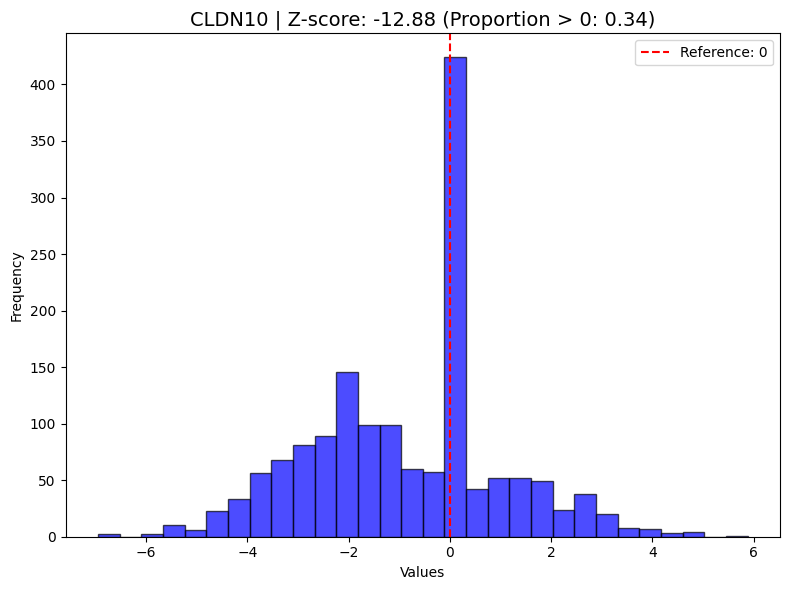

Plotting: KRT4
adjusted p-value: 0.0


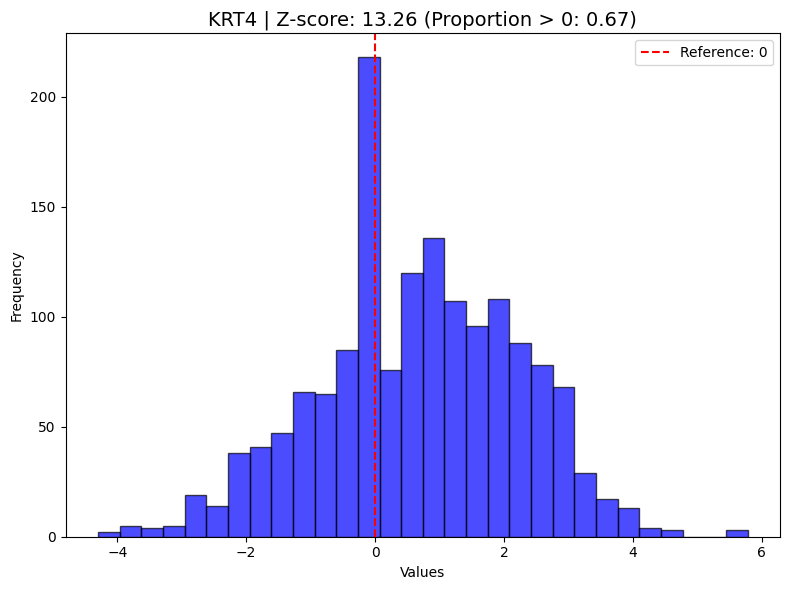

Plotting: DUSP5
adjusted p-value: 0.0


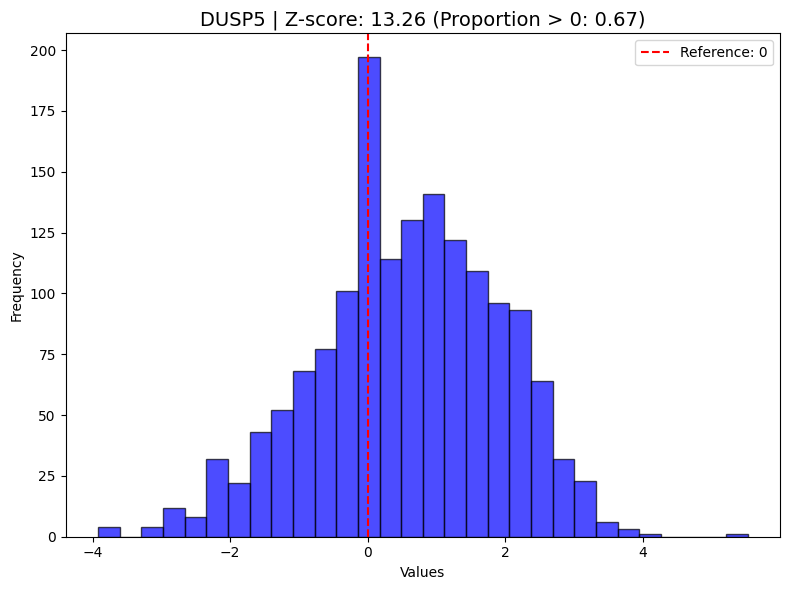

Plotting: ITPKC
adjusted p-value: 0.0


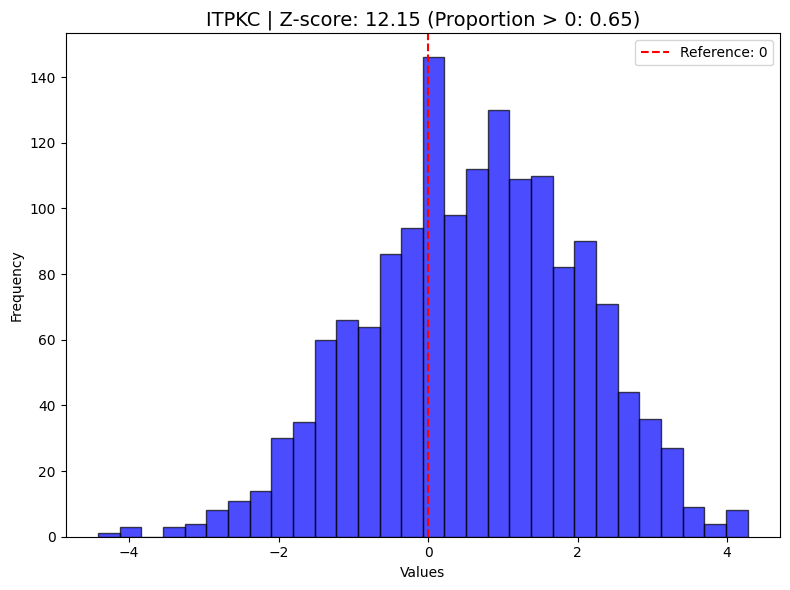

Plotting: NDRG1
adjusted p-value: 0.0


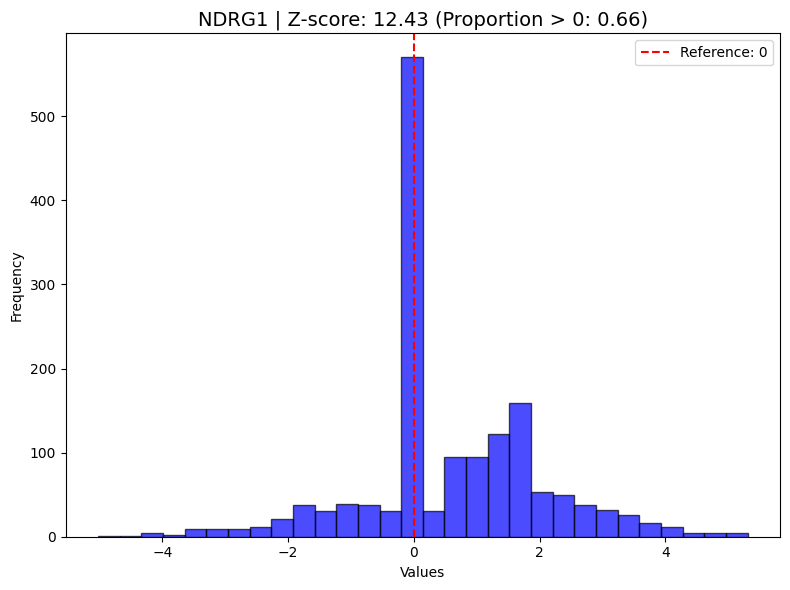

Plotting: KRT5
adjusted p-value: 0.0


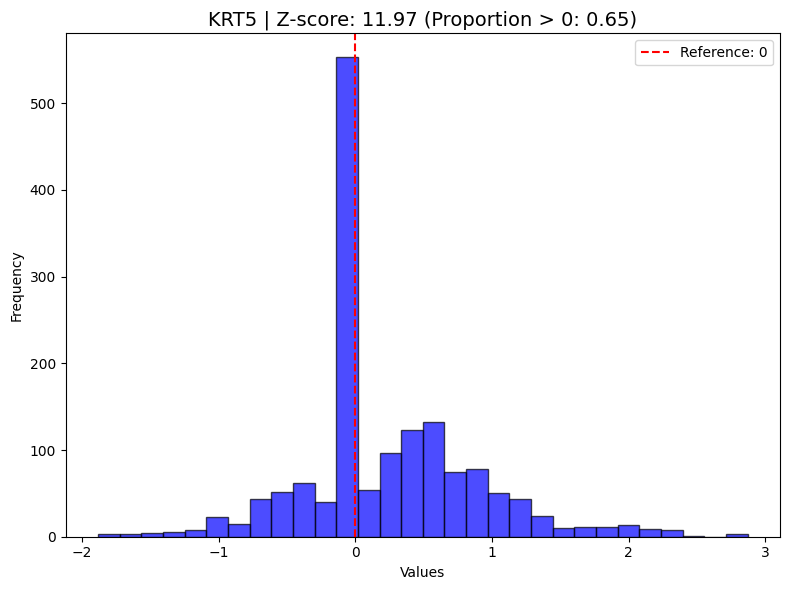

Plotting: ATF3
adjusted p-value: 0.0


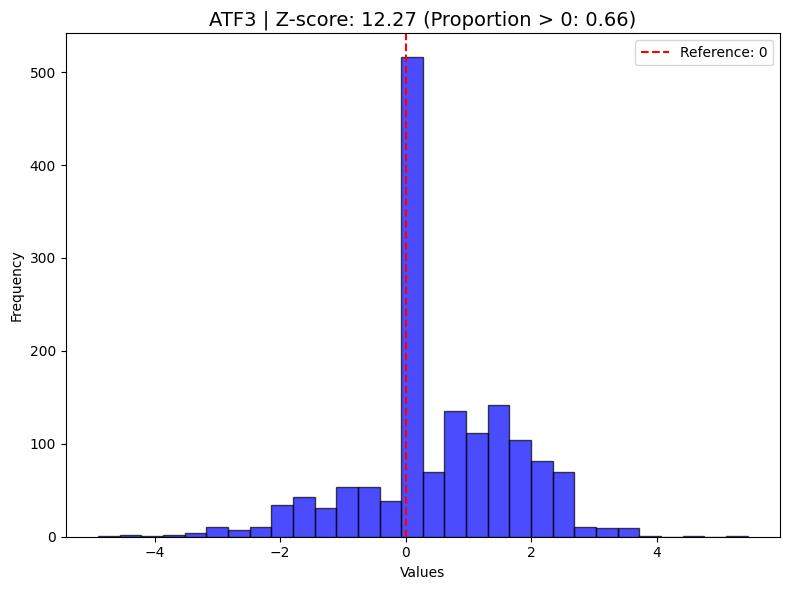

Plotting: ATP12A
adjusted p-value: 0.0


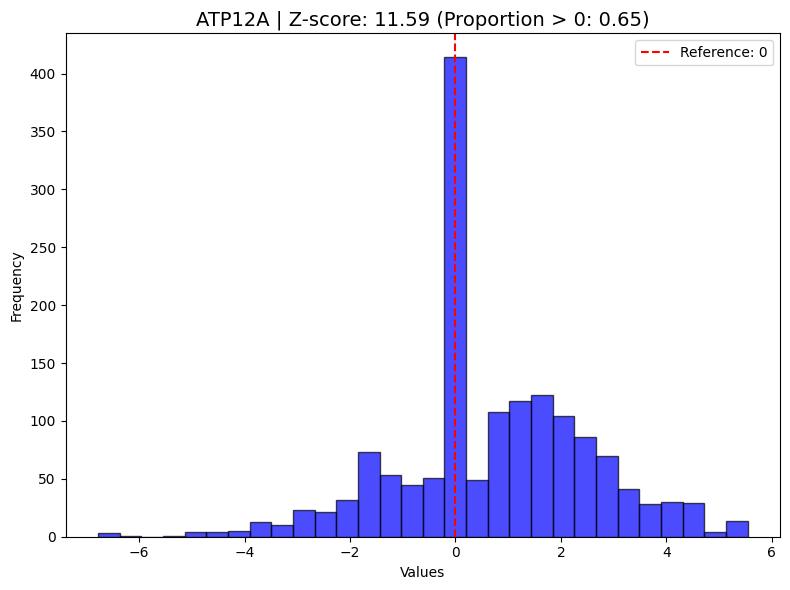

Plotting: GADD45B
adjusted p-value: 0.0


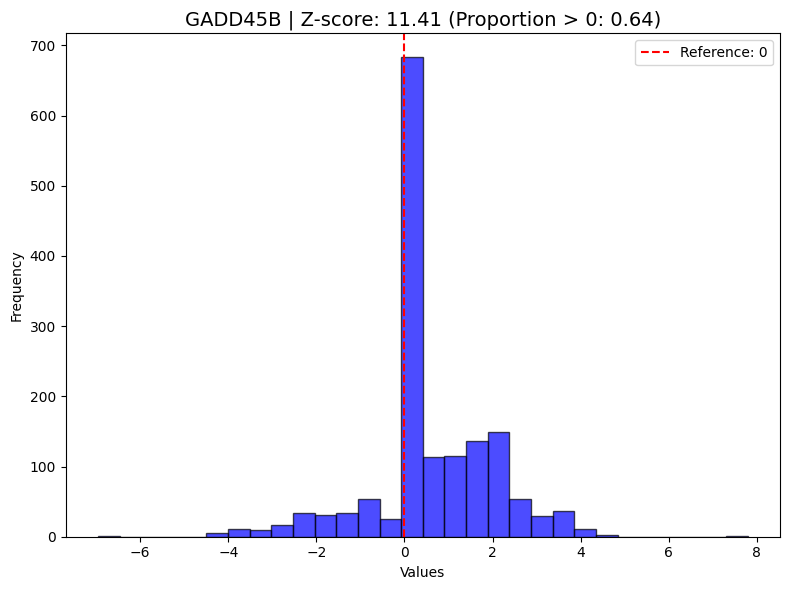

Plotting: SOX4
adjusted p-value: 0.0


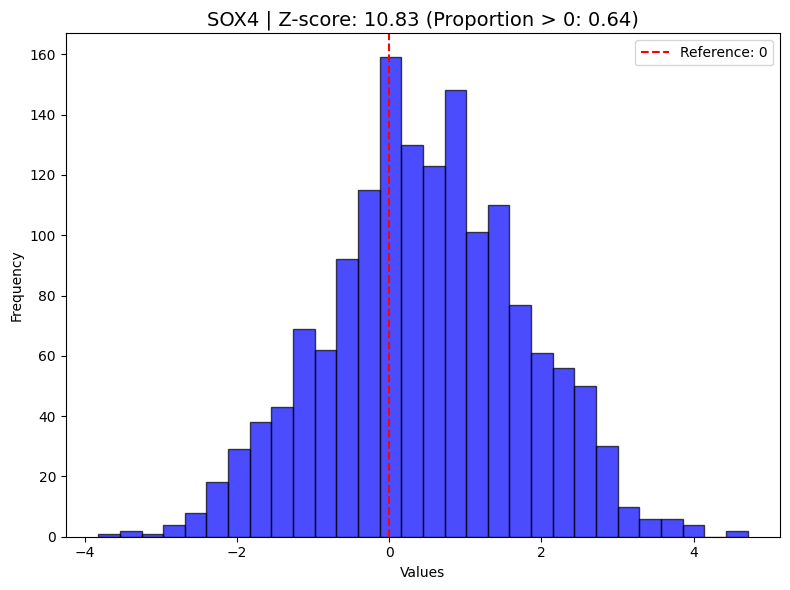

Plotting: TSPAN8
adjusted p-value: 0.0


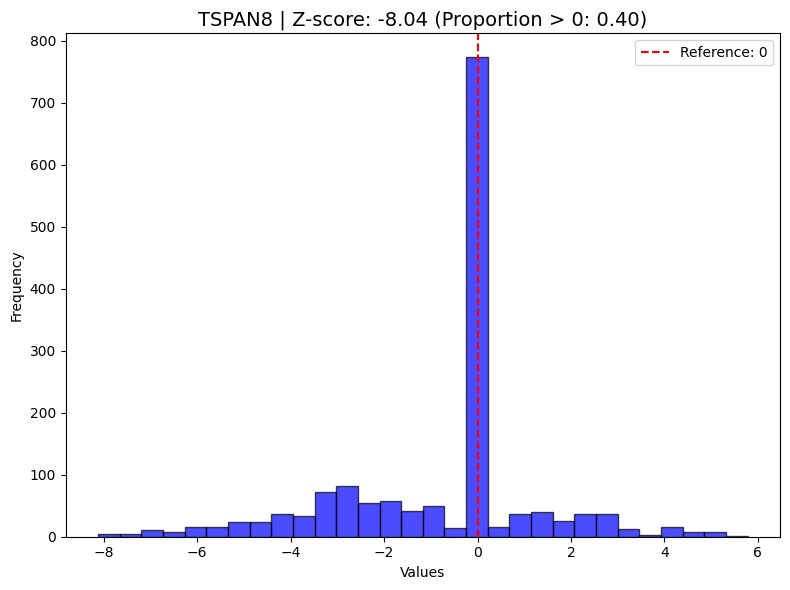

array([ 2.10488504,  3.65253936, -0.78371432, ...,  4.26336906,
        4.32332922, -0.15309325])

In [5]:
adata=sc.read_h5ad("./virus/b-0--c-1__ITE.h5ad")
indices=adata.obs["cell_type1021"]=="Secretory"
Plot_and_Estimate_CATE_adata(adata,indices)
print("="*20)
Plot_and_Estimate_CATE_adata(adata,indices,parametric=True)

# For CINMEA-OT

In [6]:
import numpy as np
import scanpy as sc
import cinemaot as co
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
def run_cinema_ot(adata, condition_key, cell_type_key,exp_label,ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    print(adata_)
    sc.pp.pca(adata_)
    print(condition_key,ref_label,exp_label,cell_type_key)
    cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_, obs_label=condition_key, ref_label=ref_label,
                                                 expr_label=exp_label, mode='parametric', thres=0.5,
                                                 smoothness=1e-5, eps=1e-3, preweight_label=cell_type_key)
    adata_.obsm['cf'] = cf.copy()
    adata_.obsm['cf'][adata_.obs[condition_key]==ref_label,:] = np.matmul(ot/np.sum(ot,axis=1)[:,None],cf[adata_.obs[condition_key]==exp_label,:])
    sc.pp.neighbors(adata_, use_rep='cf')

    sc.tl.umap(adata_, random_state=1)
    print("Effect modifier (called confounder in this paper) space:")
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)
    
    return de

AnnData object with n_obs × n_vars = 12255 × 3608
    obs: 'batch', 'leiden', 'cell_type1021', 'perturbation', 'condition', 'condition_fake'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 12255 × 2000
    obs: 'batch', 'leiden', 'cell_type1021', 'perturbation', 'condition', 'condition_fake'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'cell_type1021_colors', 'cell_type1021_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
condition MOCK CSE cell_type1021
E

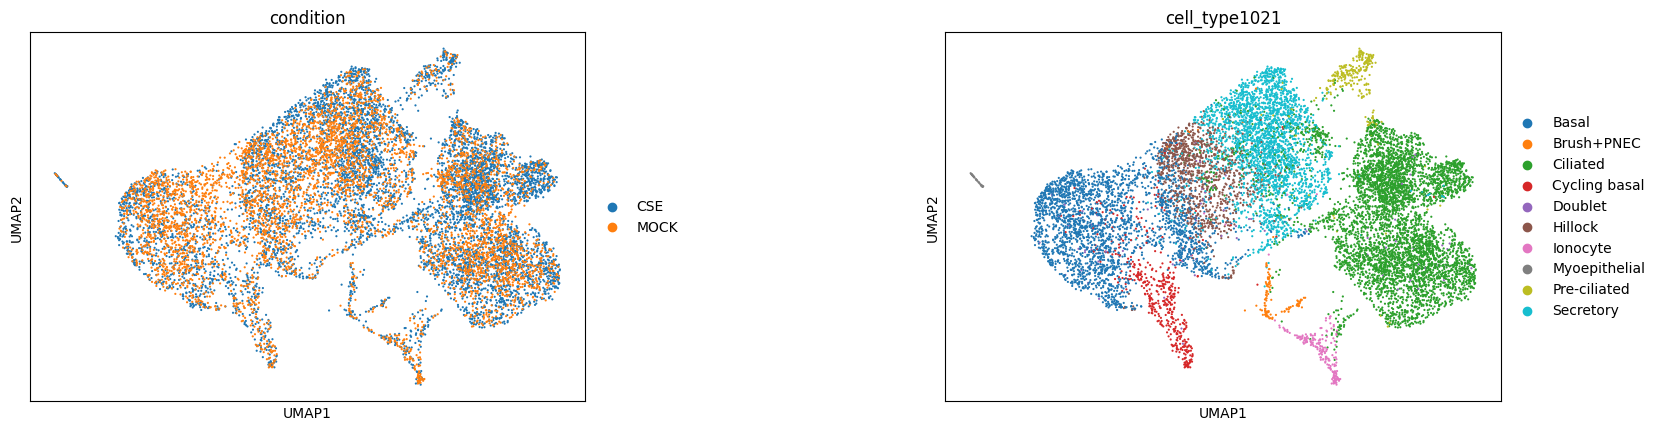

AnnData object with n_obs × n_vars = 5168 × 2000
    obs: 'batch', 'leiden', 'cell_type1021', 'perturbation', 'condition', 'condition_fake'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_embedding'
Number of genes with ITE adjusted p-values less than 0.01 1971
Selected most significant genes:
           Gene    Z score  Adjusted_p
0        PTGER3 -32.171416         0.0
1    AC116616.1 -32.171416         0.0
2    AL357153.3 -32.171416         0.0
3         SYNE3 -32.171416         0.0
4         SMILR -32.171416         0.0
5        LRRC63 -32.171416         0.0
6   EPPIN-WFDC6 -32.171416         0.0
7       CYP24A1 -32.171416         0.0
8    AC079354.1 -32.171416         0.0
9    AL356421.2 -32.171416         0.0
10         RTN1 -32.171416         0.0
11   AL160396.1 -32.171416         0.0
12    LINC02231 -32.171416         0.0
13   AC108063.1 -32.171416         0.0
14   AC112487.1 -32.171416         0.0
15   AC093512.2 -32.171416    

<Figure size 1000x600 with 0 Axes>

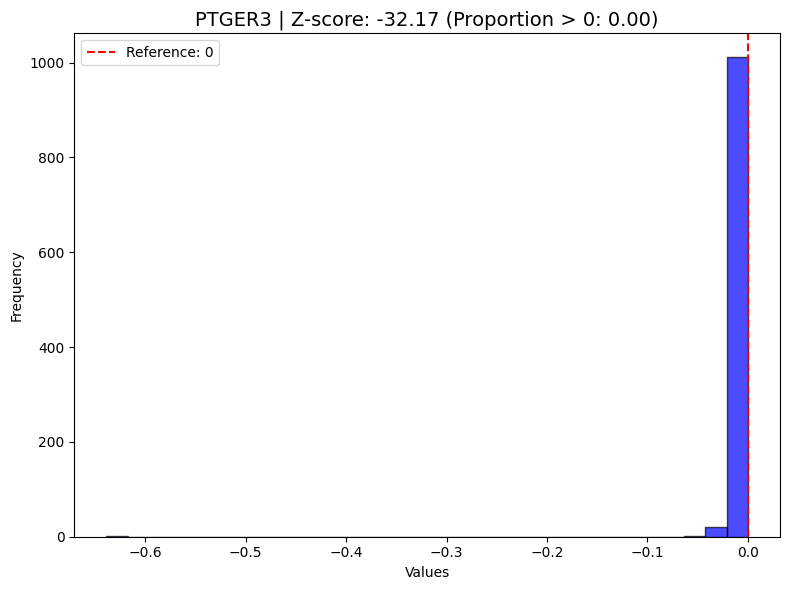

Plotting: AC116616.1
adjusted p-value: 0.0


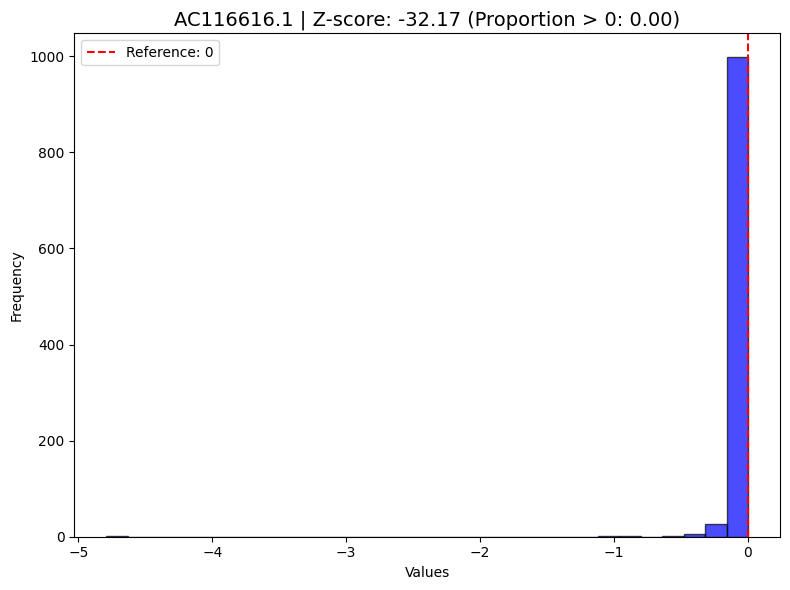

Plotting: AL357153.3
adjusted p-value: 0.0


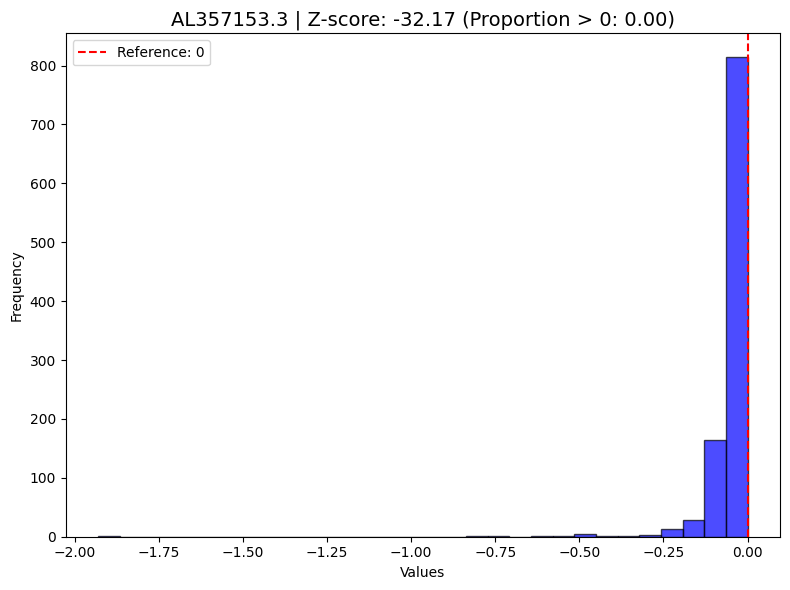

Plotting: SYNE3
adjusted p-value: 0.0


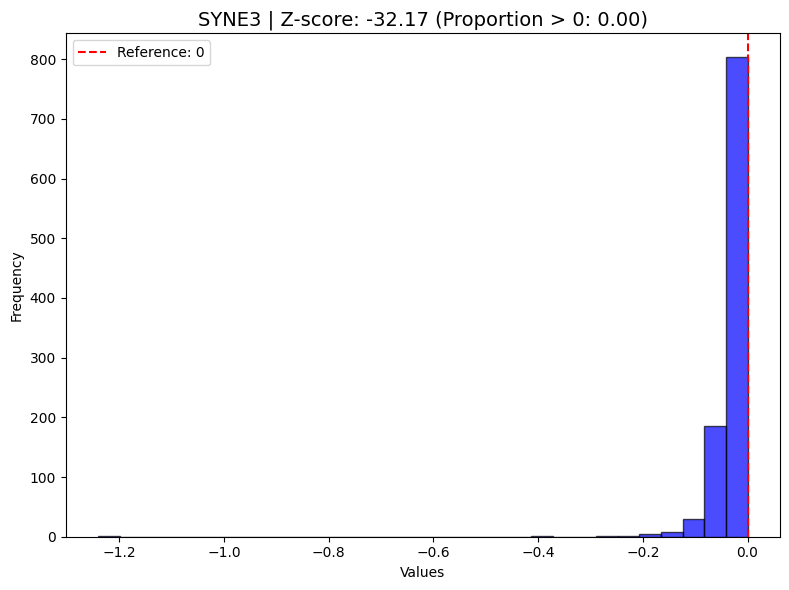

Plotting: SMILR
adjusted p-value: 0.0


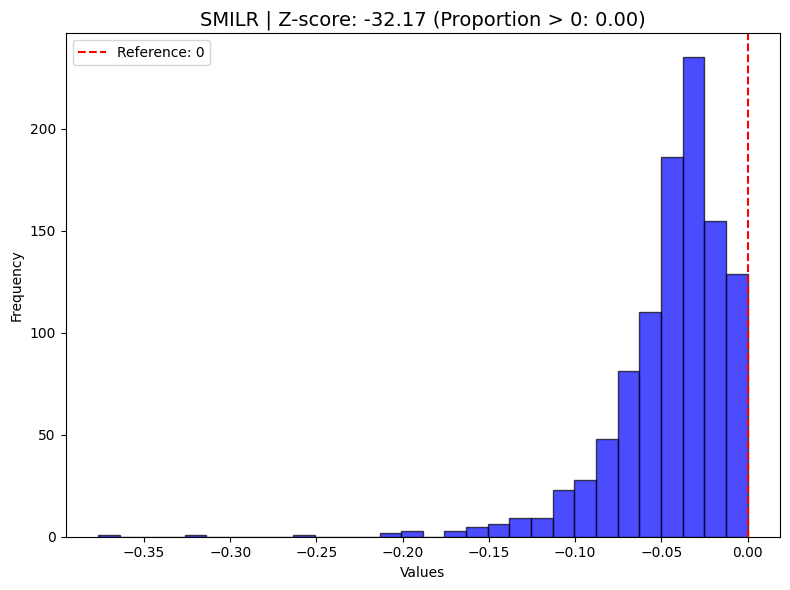

Plotting: LRRC63
adjusted p-value: 0.0


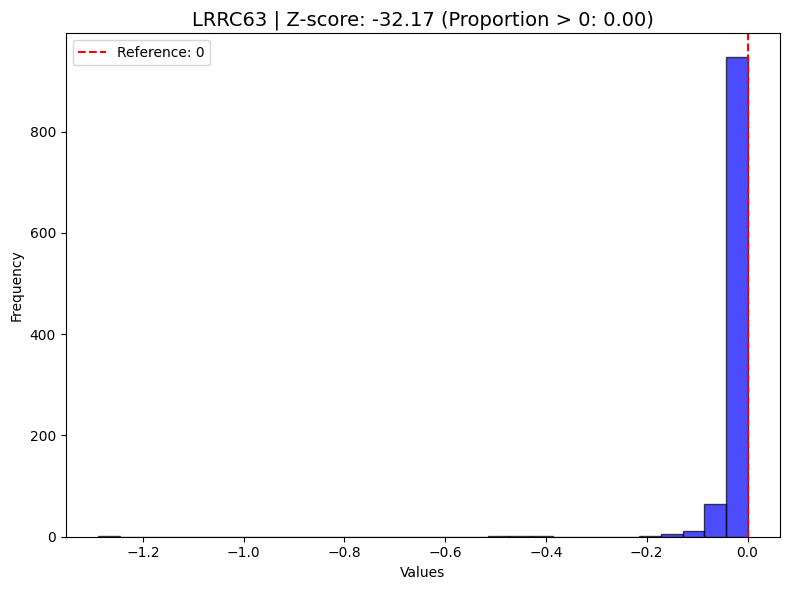

Plotting: EPPIN-WFDC6
adjusted p-value: 0.0


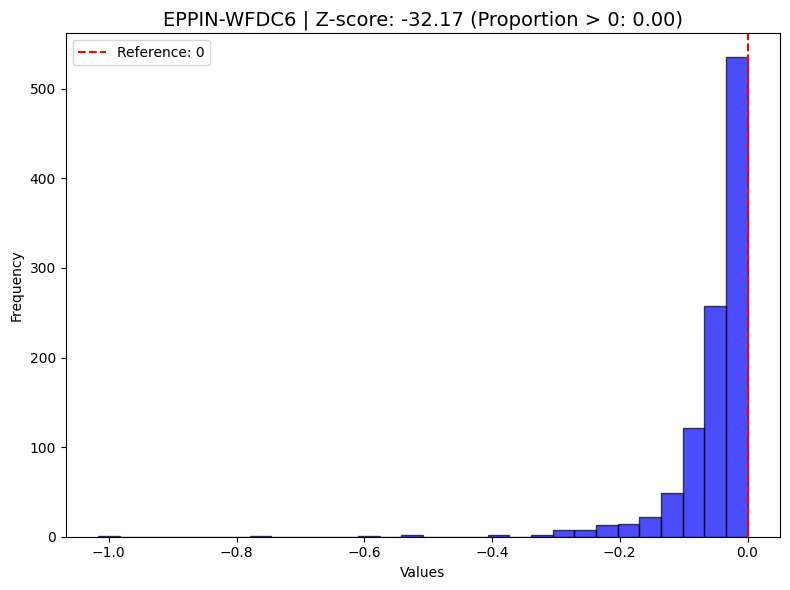

Plotting: CYP24A1
adjusted p-value: 0.0


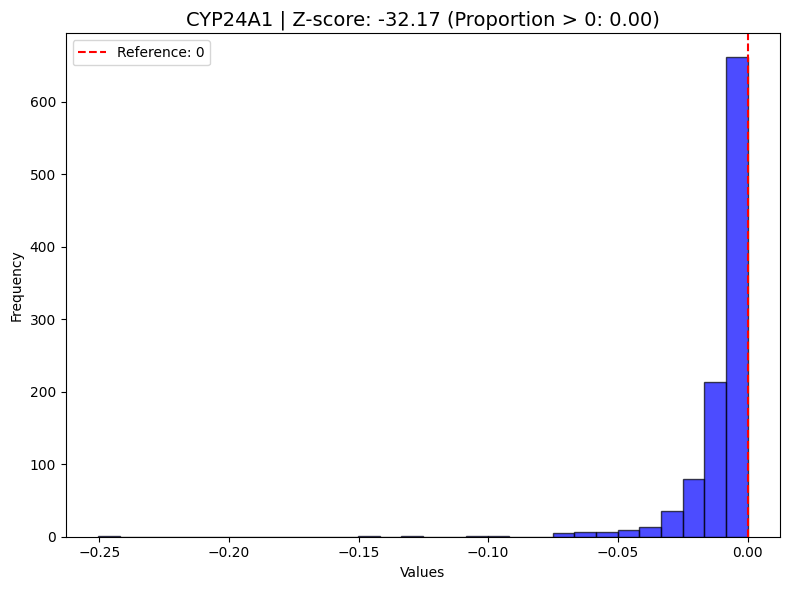

Plotting: AC079354.1
adjusted p-value: 0.0


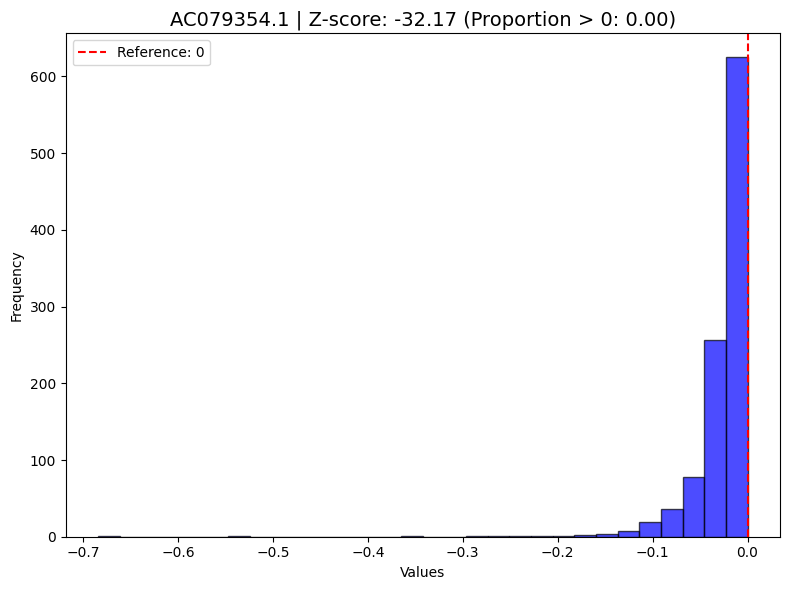

Plotting: AL356421.2
adjusted p-value: 0.0


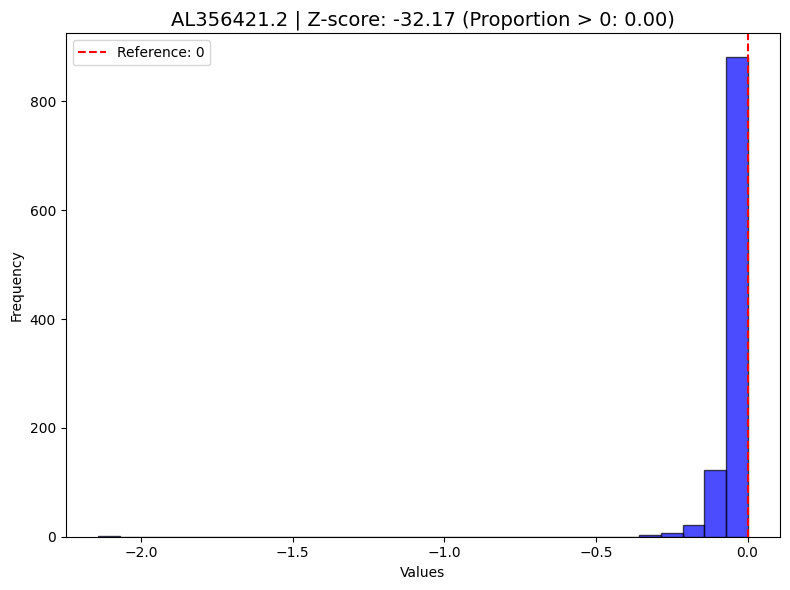

Plotting: RTN1
adjusted p-value: 0.0


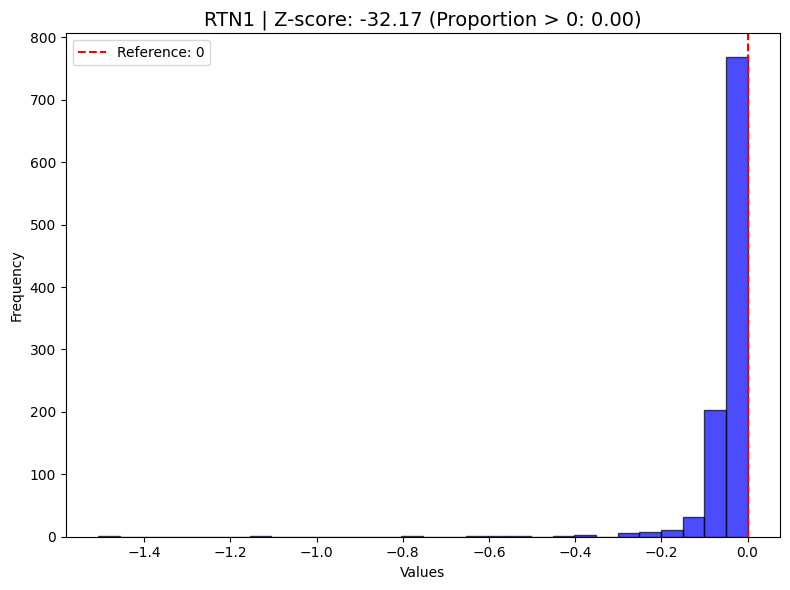

Plotting: AL160396.1
adjusted p-value: 0.0


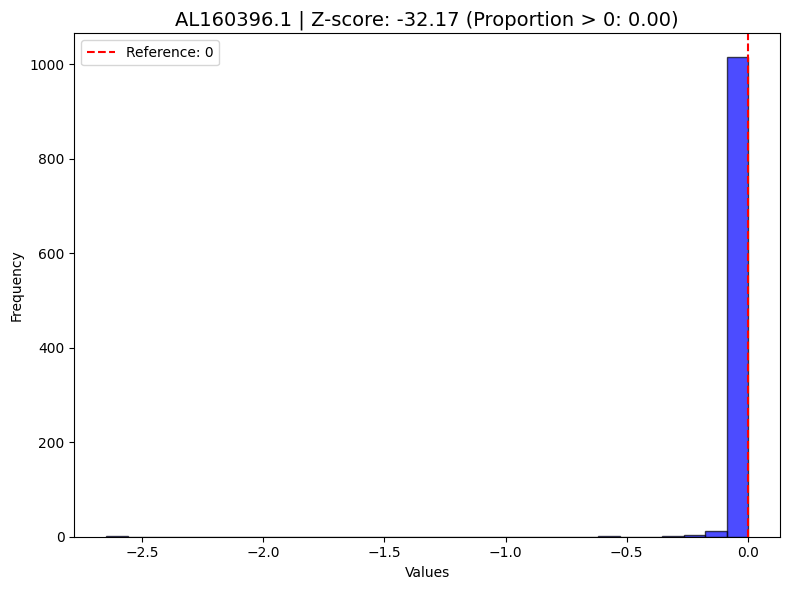

Plotting: LINC02231
adjusted p-value: 0.0


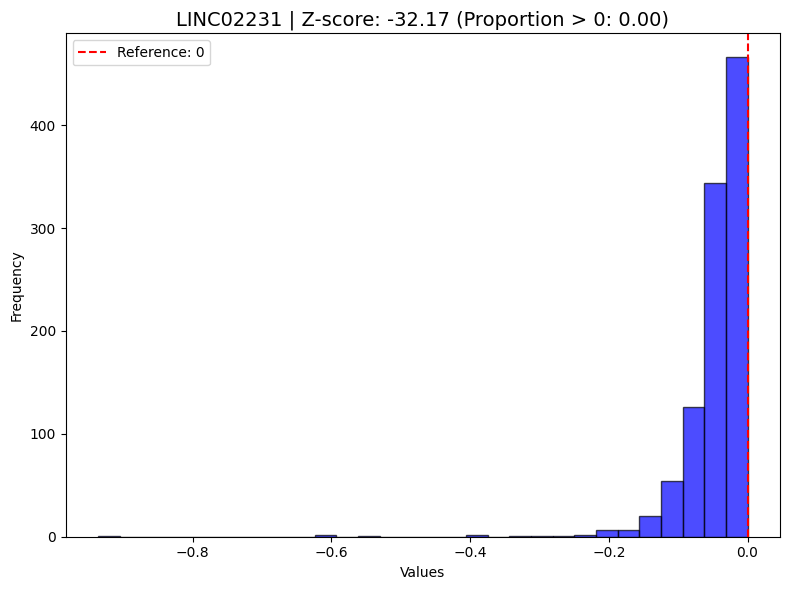

Plotting: AC108063.1
adjusted p-value: 0.0


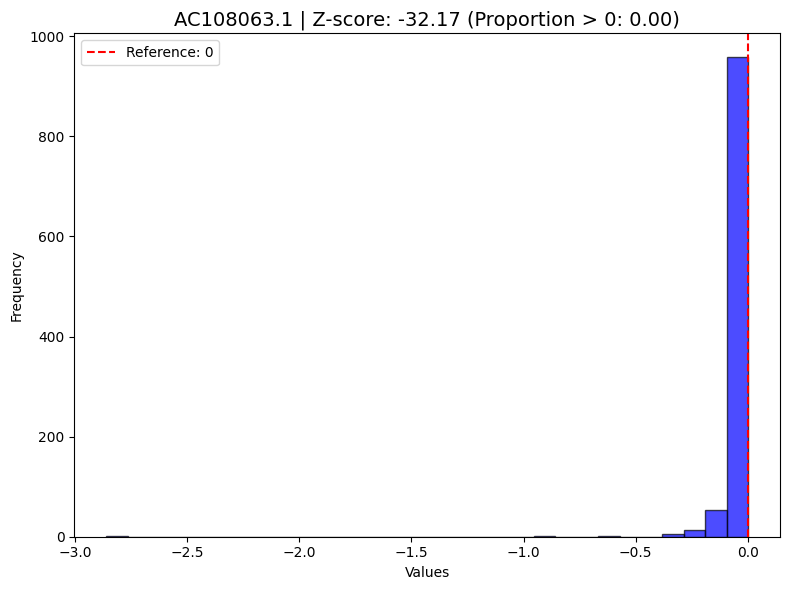

Plotting: AC112487.1
adjusted p-value: 0.0


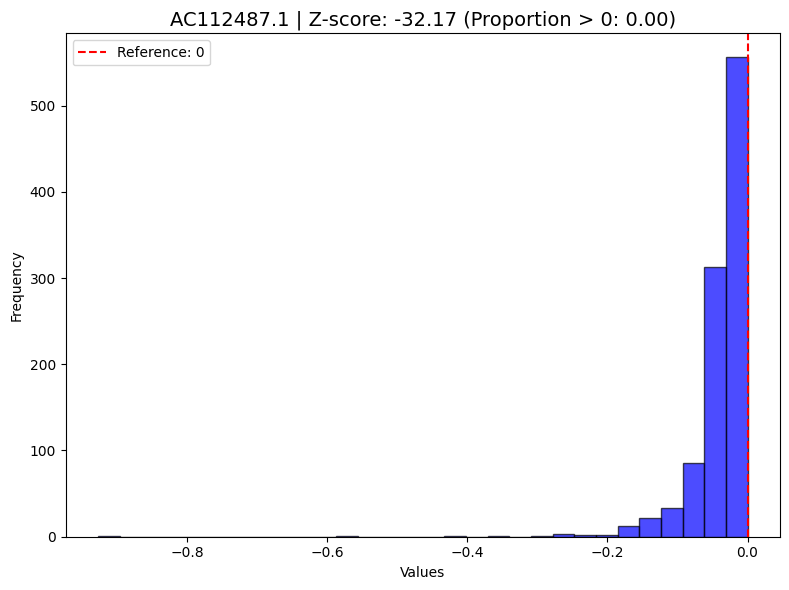

Plotting: AC093512.2
adjusted p-value: 0.0


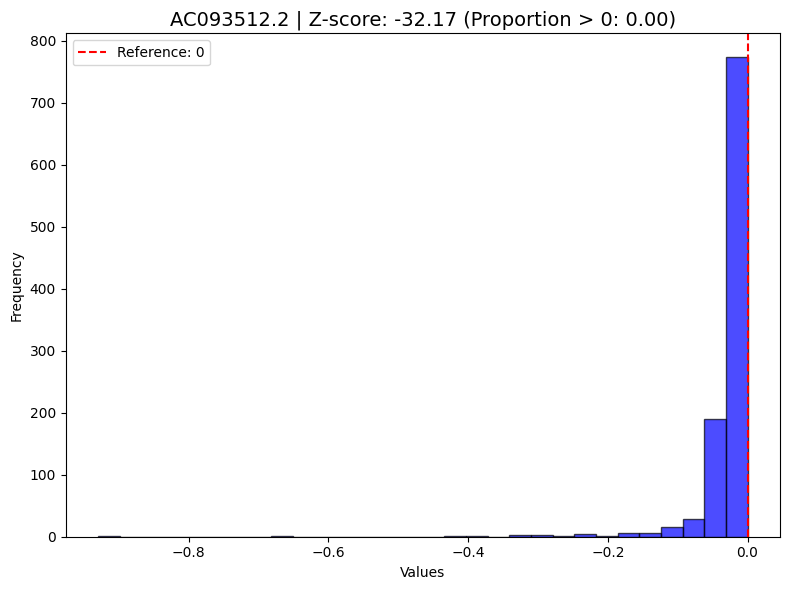

Plotting: CPB1
adjusted p-value: 0.0


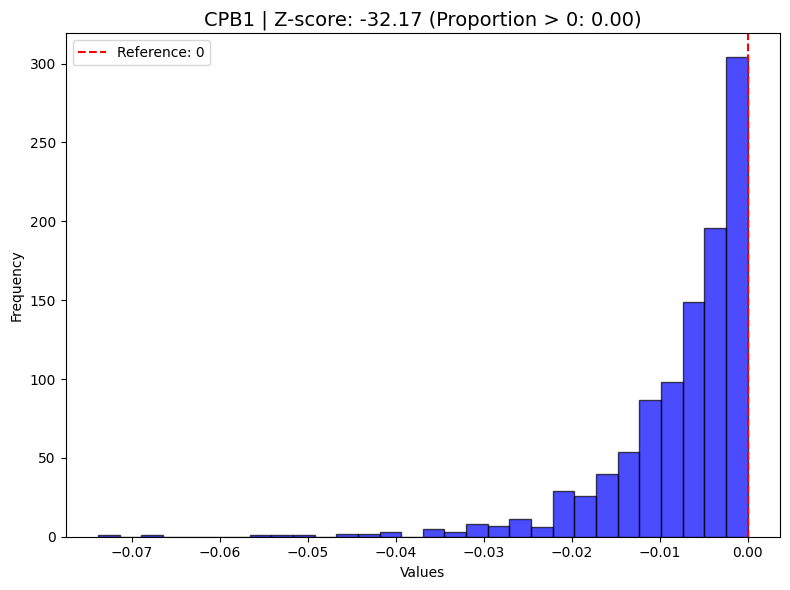

Plotting: CALCA
adjusted p-value: 0.0


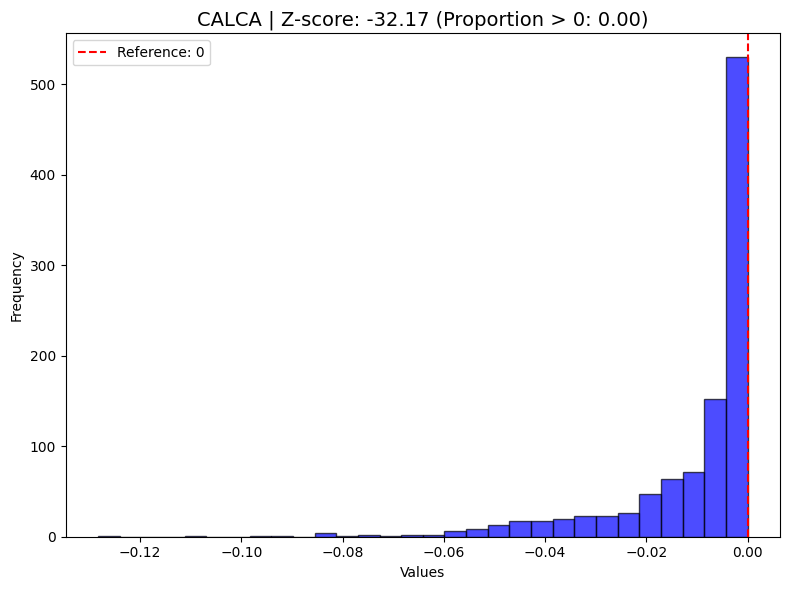

Plotting: GUCY2F
adjusted p-value: 0.0


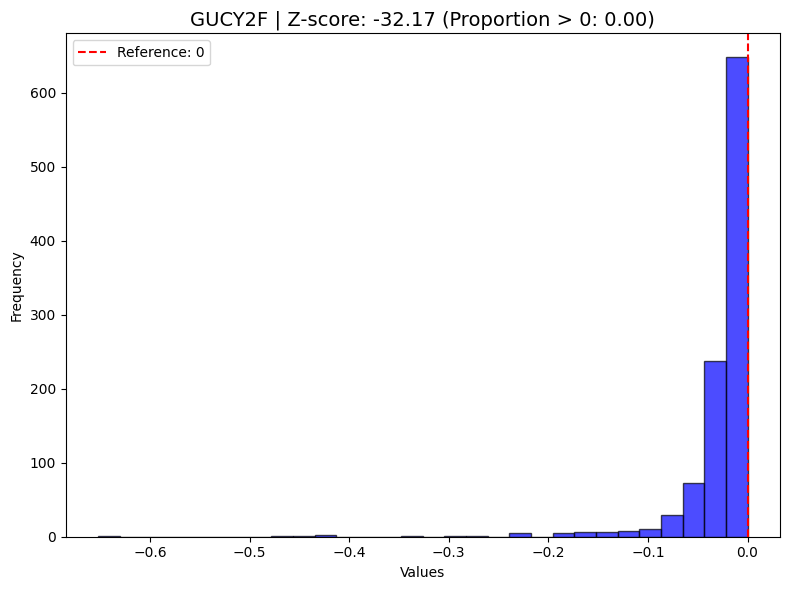

Plotting: AC092832.2
adjusted p-value: 0.0


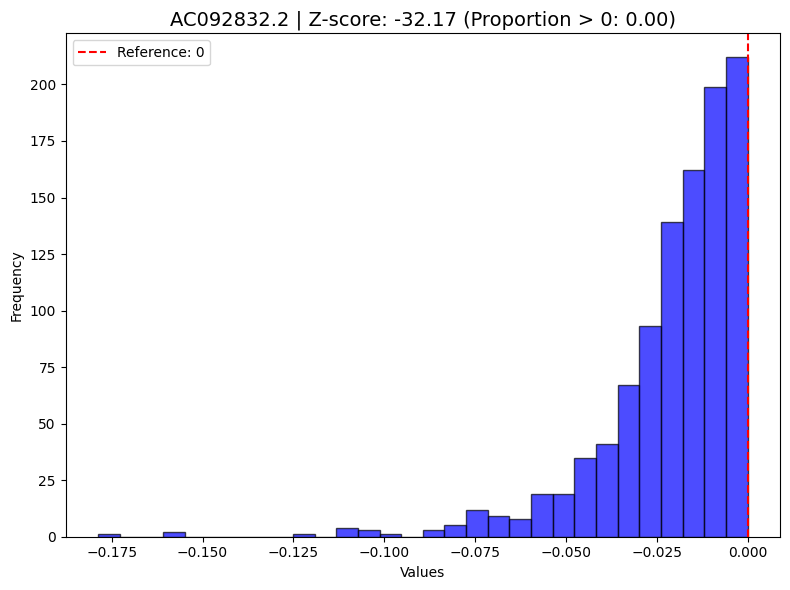

Number of genes with ITE adjusted p-values less than 0.01 795
Selected most significant genes:
           Gene    Z score  Adjusted_p
0         SMILR -41.120059         0.0
1       C8orf34 -33.218173         0.0
2    AC092832.2 -32.987924         0.0
3          CPB1 -29.027952         0.0
4     LINC02345 -27.598953         0.0
5     LINC02231 -26.391133         0.0
6         PAMR1 -25.986606         0.0
7        STOML3 -25.946775         0.0
8    AC112487.1 -25.092487         0.0
9          BTG4 -24.352967         0.0
10       LRRC36 -23.629476         0.0
11         FOSB  23.551952         0.0
12         GRM7 -23.525561         0.0
13        TTC25 -23.462222         0.0
14  EPPIN-WFDC6 -23.353818         0.0
15           C3  22.180617         0.0
16        CALCA -22.051961         0.0
17    LINC01170 -21.605463         0.0
18   AC079354.1 -21.475586         0.0
19        ENKUR -21.424202         0.0
Plotting: SMILR
adjusted p-value: 0.0


<Figure size 1000x600 with 0 Axes>

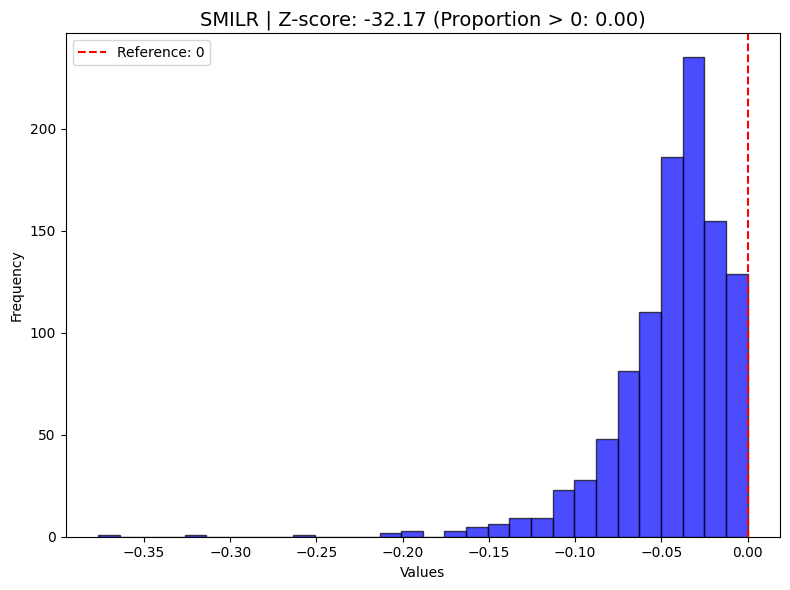

Plotting: C8orf34
adjusted p-value: 0.0


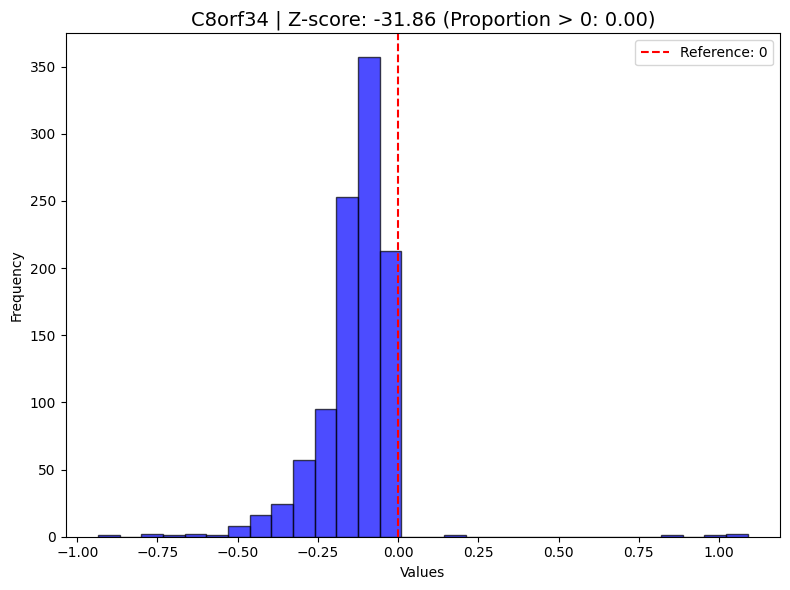

Plotting: AC092832.2
adjusted p-value: 0.0


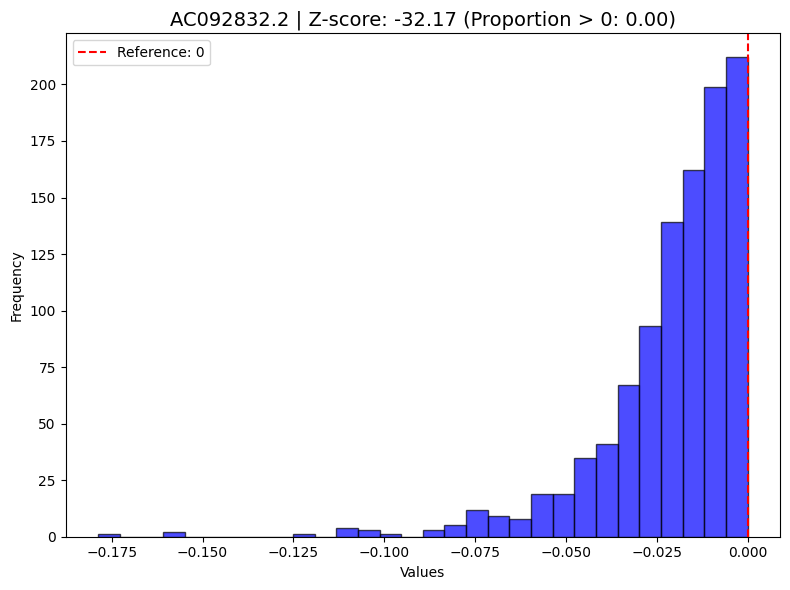

Plotting: CPB1
adjusted p-value: 0.0


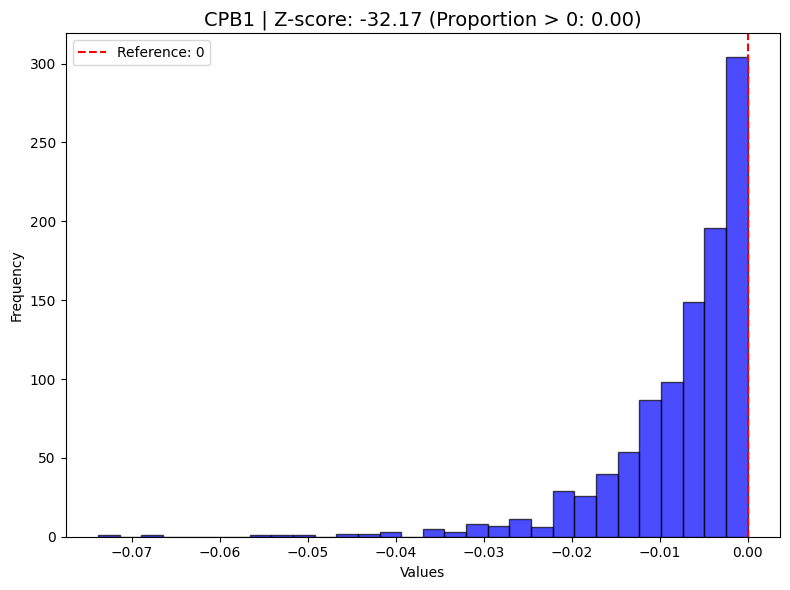

Plotting: LINC02345
adjusted p-value: 0.0


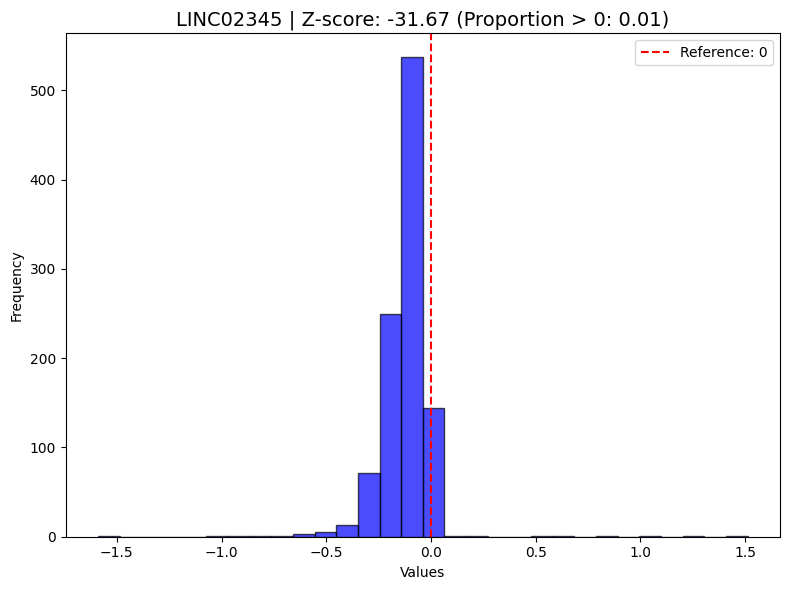

Plotting: LINC02231
adjusted p-value: 0.0


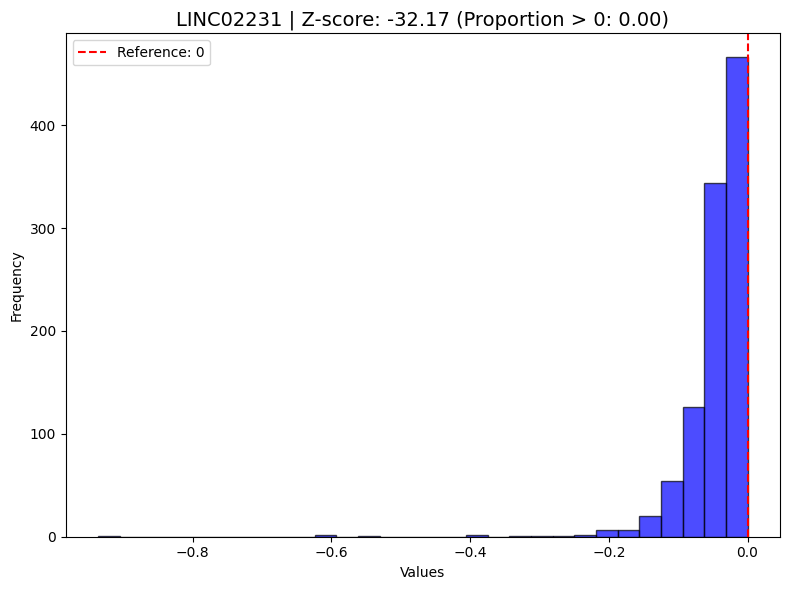

Plotting: PAMR1
adjusted p-value: 0.0


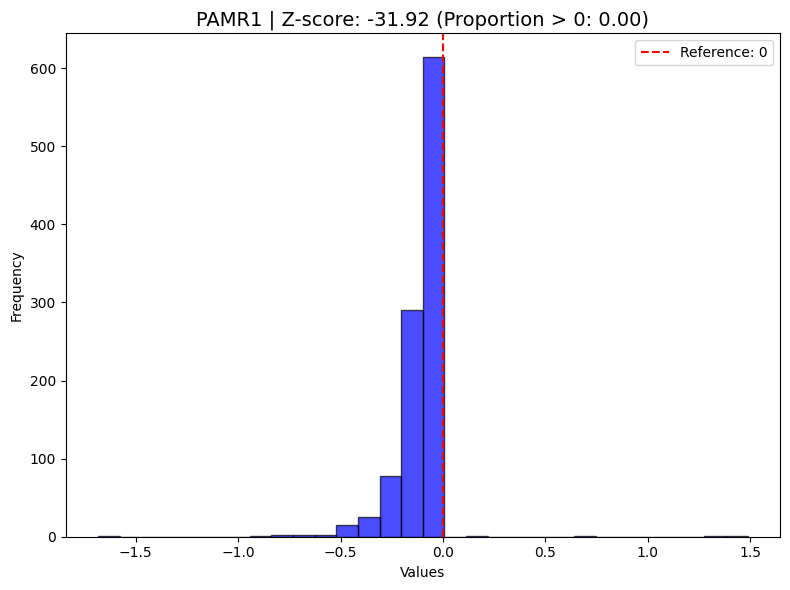

Plotting: STOML3
adjusted p-value: 0.0


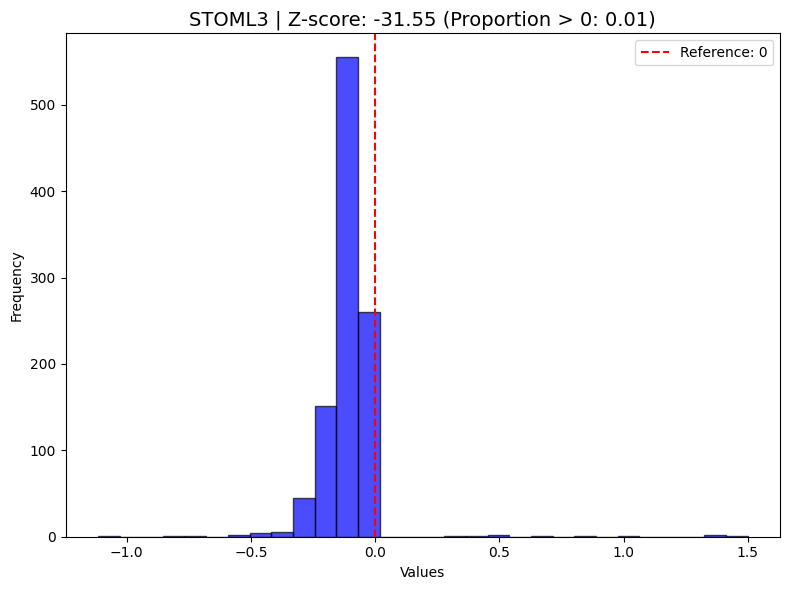

Plotting: AC112487.1
adjusted p-value: 0.0


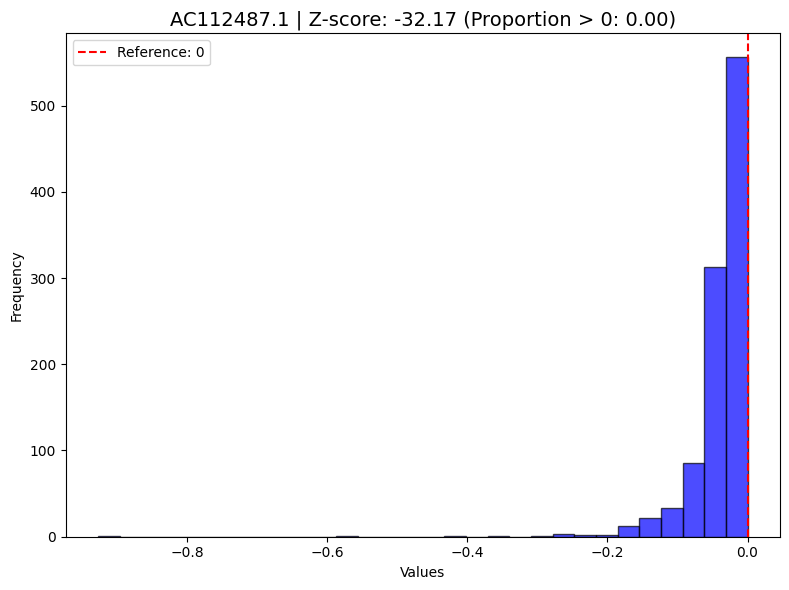

Plotting: BTG4
adjusted p-value: 0.0


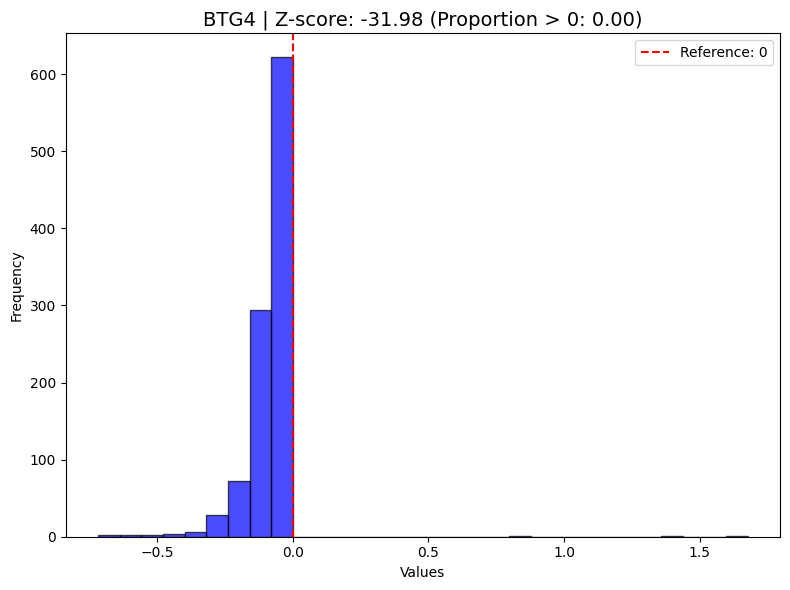

Plotting: LRRC36
adjusted p-value: 0.0


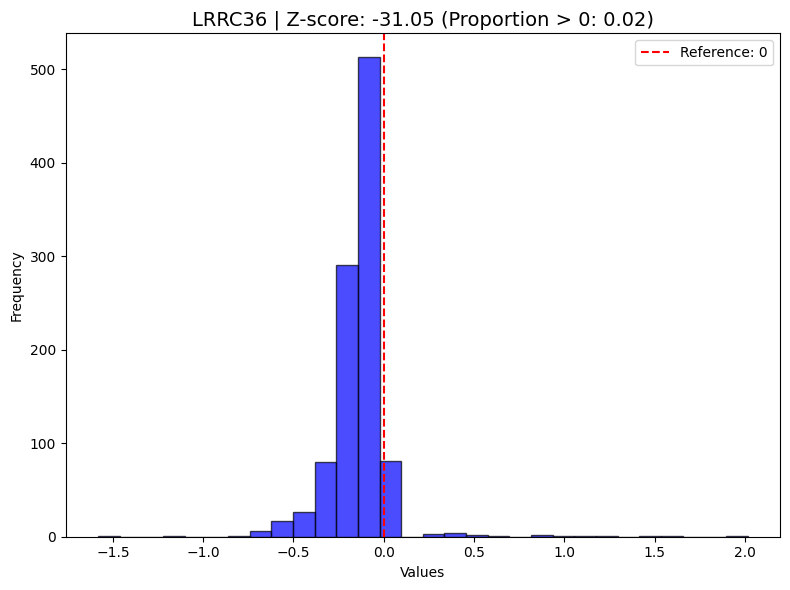

Plotting: FOSB
adjusted p-value: 0.0


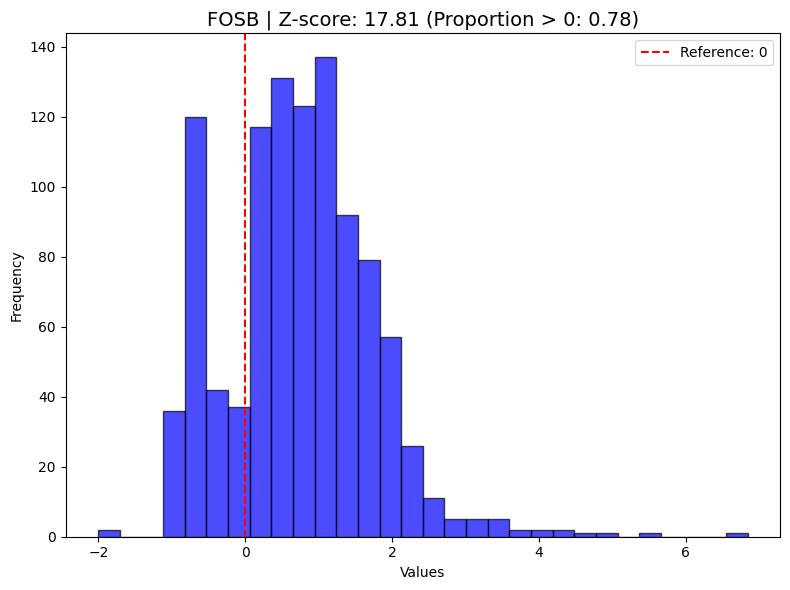

Plotting: GRM7
adjusted p-value: 0.0


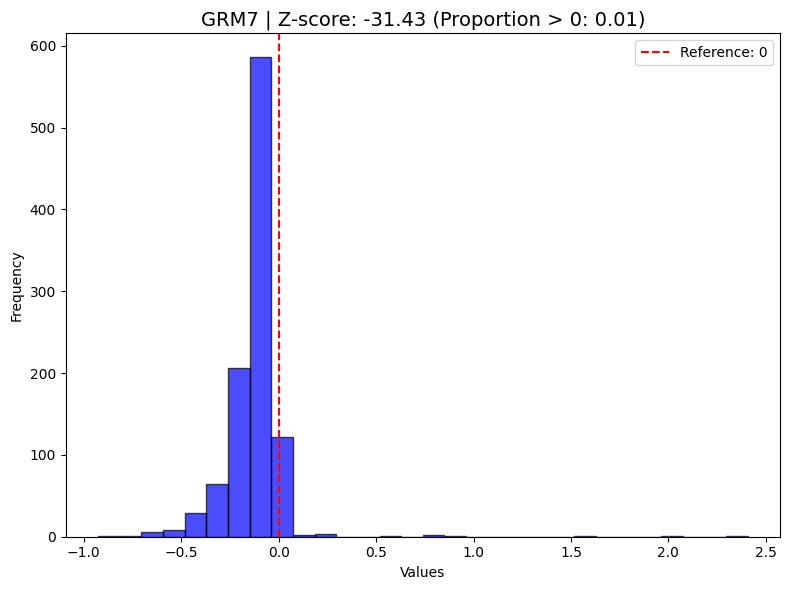

Plotting: TTC25
adjusted p-value: 0.0


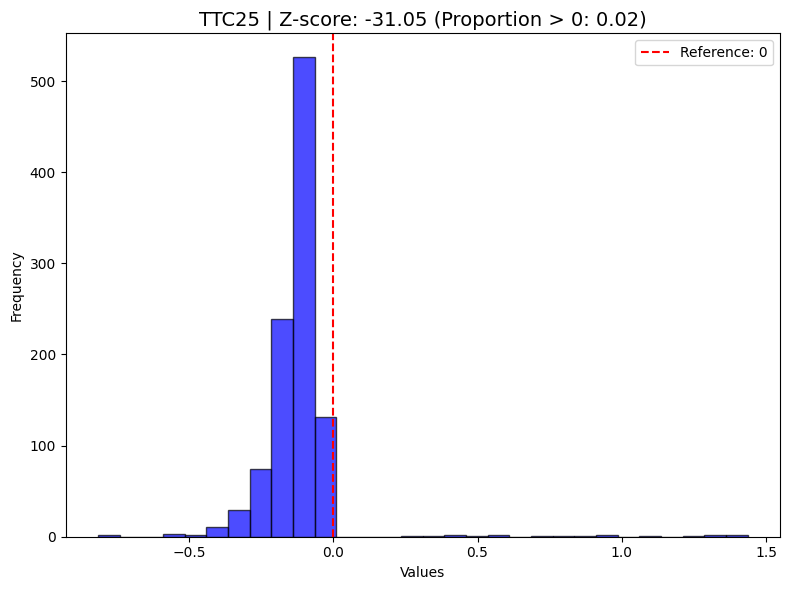

Plotting: EPPIN-WFDC6
adjusted p-value: 0.0


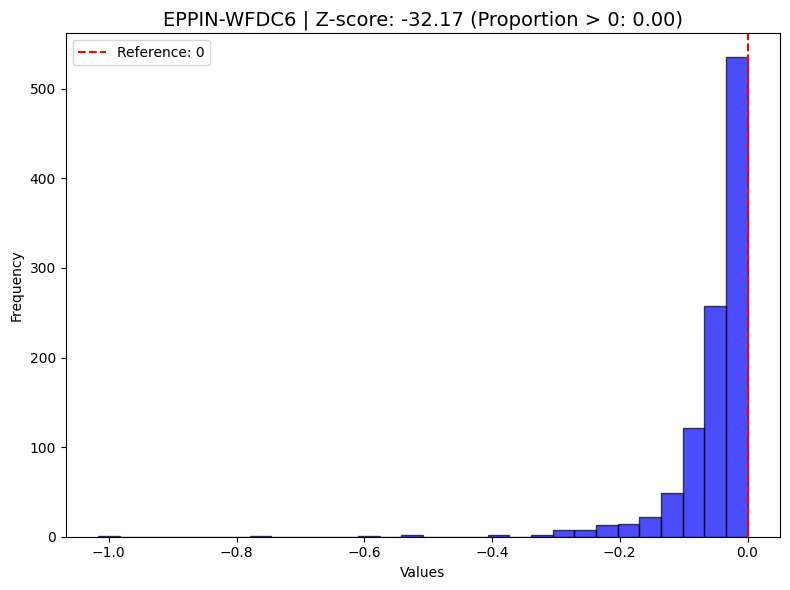

Plotting: C3
adjusted p-value: 0.0


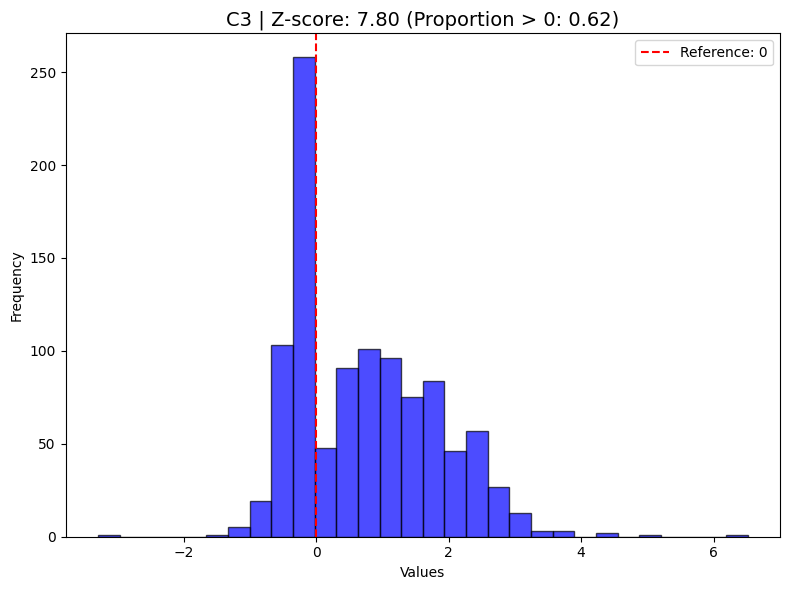

Plotting: CALCA
adjusted p-value: 0.0


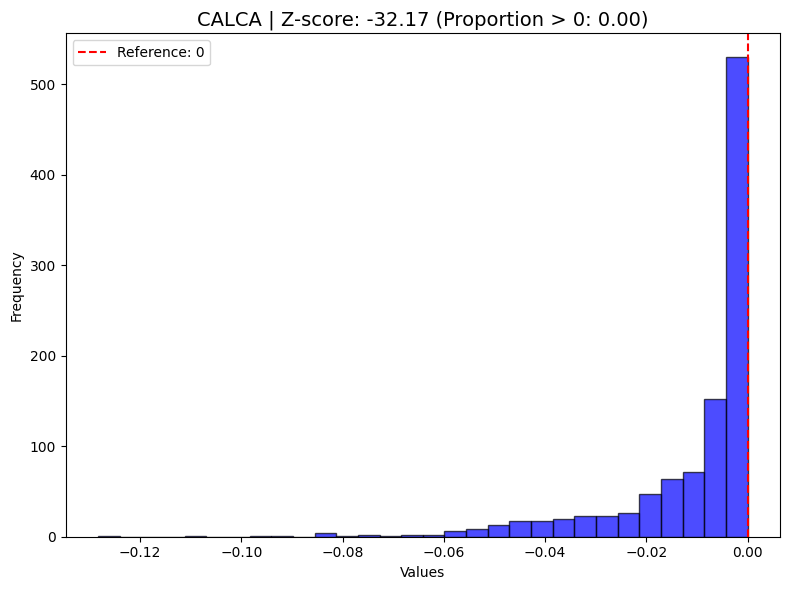

Plotting: LINC01170
adjusted p-value: 0.0


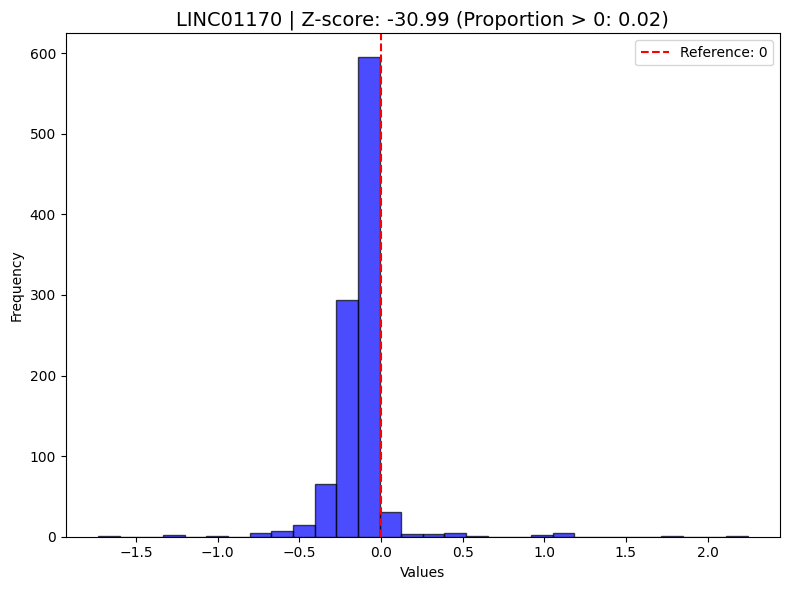

Plotting: AC079354.1
adjusted p-value: 0.0


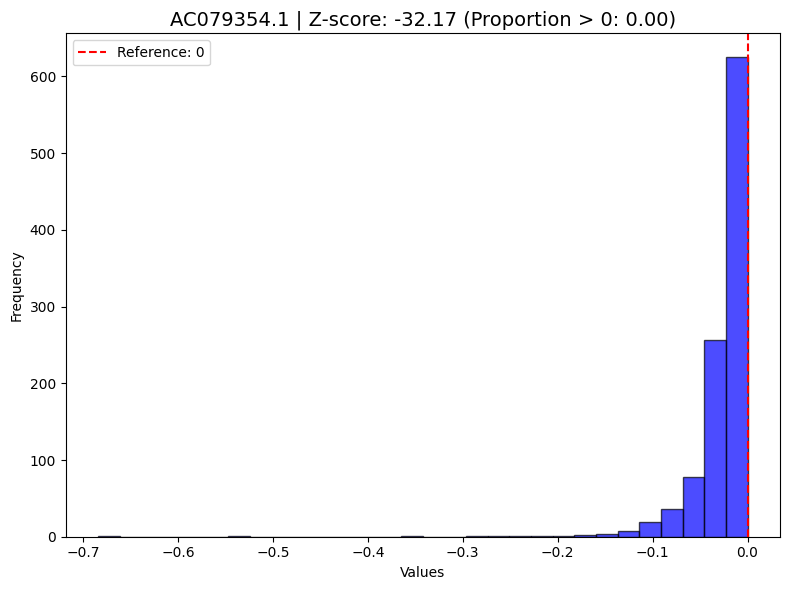

Plotting: ENKUR
adjusted p-value: 0.0


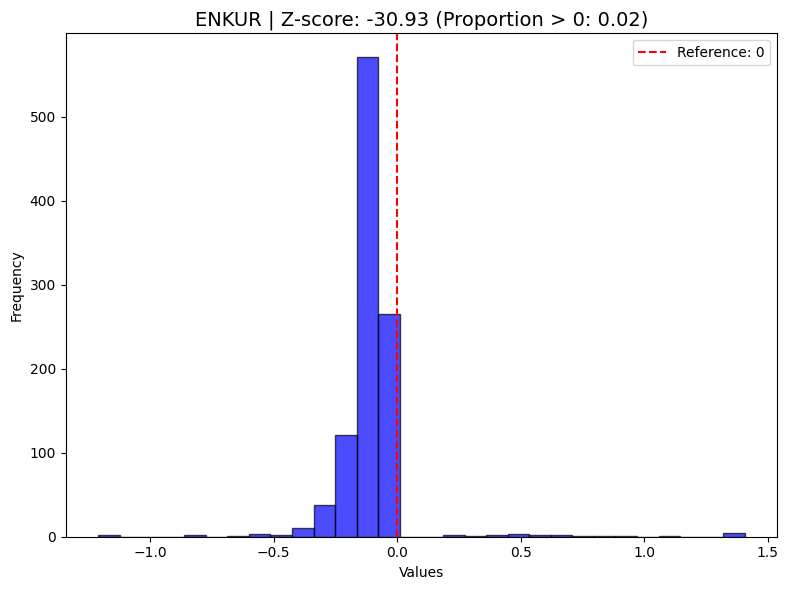

array([  1.01879106,  -2.11670703,   0.51056867, ...,   2.41471447,
        -3.50518757, -18.02140648])

In [9]:
adata=sc.read_h5ad("../data/rvcse_221021.h5ad")
adata=adata[adata.obs["batch"].isin(['CSE',"MOCK"])].copy()
adata.obs["perturbation"]=adata.obs["batch"].copy()
adata.obs["condition"]=adata.obs["batch"].copy()

adata.obs["condition_fake"]=np.random.permutation(adata.obs["condition"].copy())#condition_fake
ITE4=run_cinema_ot(adata=adata, condition_key="condition", cell_type_key='cell_type1021', exp_label='CSE', ref_label="MOCK", dataset_name="virus")
print(ITE4)
indices=ITE4.obs["cell_type1021"]=="Secretory"
Plot_and_Estimate_CATE_adata(ITE4,indices)

print("="*20)
Plot_and_Estimate_CATE_adata(ITE4,indices,parametric=True)